In [64]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [65]:
from fastai.text.all import *
from xcube.text.all import *
from fastai.metrics import accuracy # there's an 'accuracy' metric in xcube as well (Deb fix name conflict later)  

Make sure we have that "beast":

In [66]:
#| eval: false
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))
print(f"GPU memory = {torch.cuda.get_device_properties(default_device()).total_memory/1024**3}GB")

ic| torch.cuda.get_device_name(default_device()): 'Quadro RTX 8000'


GPU memory = 44.99969482421875GB


In [67]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
source = untar_xxx(XURLs.MIMIC3)
source_l2r = untar_xxx(XURLs.MIMIC3_L2R)

Setting some environment variables:

In [69]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Setting defaults for pandas and matplotlib:

In [70]:
# Set the default figure size
plt.rcParams["figure.figsize"] = (8, 4)

Altering some default jupyter settings:

In [71]:
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last" # "all"

# Training an XML Text Classifier

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

For the backward LM:

In [ ]:
dls_lm_r = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True, backwards=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos admission date discharge date date of birth sex m history of present illness first name8 namepattern2 known lastname is the firstborn of triplets at week gestation born to a year old gravida para woman immune rpr non reactive hepatitis b surface antigen negative group beta strep status unknown this was an intrauterine insemination achieved pregnancy the pregnancy was uncomplicated until when mother was admitted for evaluation of pregnancy induced hypertension she was treated with betamethasone and discharged home she,admission date discharge date date of birth sex m history of present illness first name8 namepattern2 known lastname is the firstborn of triplets at week gestation born to a year old gravida para woman immune rpr non reactive hepatitis b surface antigen negative group beta strep status unknown this was an intrauterine insemination achieved pregnancy the pregnancy was uncomplicated until when mother was admitted for evaluation of pregnancy induced hypertension she was treated with betamethasone and discharged home she was
1,occluded rca with l to r collaterals the femoral sheath was sewn in started on heparin and transferred to hospital1 for surgical revascularization past medical history coronary artery diease s p myocardial infarction s p pci to rca subarachnoid hemorrhage secondary to streptokinase hypertension hyperlipidemia hiatal hernia gastritis depression reactive airway disease s p ppm placement for 2nd degree av block social history history of smoking having quit in with a pack year history family history strong family history of,rca with l to r collaterals the femoral sheath was sewn in started on heparin and transferred to hospital1 for surgical revascularization past medical history coronary artery diease s p myocardial infarction s p pci to rca subarachnoid hemorrhage secondary to streptokinase hypertension hyperlipidemia hiatal hernia gastritis depression reactive airway disease s p ppm placement for 2nd degree av block social history history of smoking having quit in with a pack year history family history strong family history of premature


In [ ]:
dls_lm_r.show_batch(max_n=2)

,text,text_
0,sb west d i basement name first doctor bldg name ward hospital lm lf name3 first lf name last name last doctor d i 30a visit fellow sb west d i name first doctor name last doctor d i 30p visit attending opat appointments up follow disease infectious garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building fax telephone md namepattern4 name last pattern1 name name11 first with am at wednesday when,west d i basement name first doctor bldg name ward hospital lm lf name3 first lf name last name last doctor d i 30a visit fellow sb west d i name first doctor name last doctor d i 30p visit attending opat appointments up follow disease infectious garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building fax telephone md namepattern4 name last pattern1 name name11 first with am at wednesday when services
1,bare and catheterization cardiac a for hospital1 to flown were you infarction myocardial or attack heart a and pain chest had you instructions discharge independent ambulatory status activity interactive and alert consciousness of level coherent and clear status mental condition discharge hyperglycemia hyperlipidemia hypertension infarction myocardial inferior acute diagnosis discharge home disposition discharge refills tablets disp pain chest for needed as year month of total a for minutes every sublingual tablet one sig sublingual tablet mg nitroglycerin day a once,and catheterization cardiac a for hospital1 to flown were you infarction myocardial or attack heart a and pain chest had you instructions discharge independent ambulatory status activity interactive and alert consciousness of level coherent and clear status mental condition discharge hyperglycemia hyperlipidemia hypertension infarction myocardial inferior acute diagnosis discharge home disposition discharge refills tablets disp pain chest for needed as year month of total a for minutes every sublingual tablet one sig sublingual tablet mg nitroglycerin day a once po


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [ ]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use) if you are working on your own dataset. In this case though `untar_xxx` has got it for you:

In [ ]:
print("\n".join(L(source.glob("**/*dls*lm*.pkl")).map(str))) # the ones with _r are for the reverse language model

/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_old.pkl


To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(source/'mimic3-9k_dls_lm.pkl')

In [ ]:
dls_lm_r = torch.load(source/'mimic3-9k_dls_lm_r.pkl')

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

And, one more for the reverse:

In [ ]:
learn_r = language_model_learner(
    dls_lm_r, AWD_LSTM, drop_mult=0.3, backwards=True,
    metrics=[accuracy, Perplexity()]).to_fp16()

Training a language model on the full datset takes a lot of time. So you can train one on a tiny dataset for illustration. Or you can skip the training and just load up the one that's pretrained and downloaded by `untar_xxx` and just do the validation.

Let's compute the learning rate using the `lr_find`:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit(15, lr=1e-5, cbs=SaveModelCallback(fname='lm_now'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.146188,2.057686,0.567773,7.827838,50:52
1,2.128464,2.056832,0.567727,7.821152,50:22
2,2.130863,2.056411,0.567697,7.817858,50:45
3,2.145324,2.056166,0.567647,7.815949,48:14
4,2.150917,2.055998,0.567635,7.814632,48:28
5,2.140279,2.055952,0.567605,7.814274,50:48
6,2.142321,2.055915,0.567604,7.813985,49:01
7,2.134698,2.055936,0.567555,7.814146,48:28
8,2.128352,2.055983,0.567532,7.814515,49:07
9,2.139955,2.056035,0.567506,7.814924,47:08


Better model found at epoch 0 with valid_loss value: 2.0576863288879395.
Better model found at epoch 1 with valid_loss value: 2.0568318367004395.
Better model found at epoch 2 with valid_loss value: 2.056410551071167.
Better model found at epoch 3 with valid_loss value: 2.056166410446167.
Better model found at epoch 4 with valid_loss value: 2.055997848510742.
Better model found at epoch 5 with valid_loss value: 2.0559520721435547.
Better model found at epoch 6 with valid_loss value: 2.055915117263794.


Reverse

In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.fit(20, lr=1e-5, cbs=SaveModelCallback(fname='lm_r_now'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.212396,2.099074,0.569185,8.158612,51:08
1,2.212062,2.098635,0.569127,8.155032,50:51
2,2.199151,2.098516,0.569043,8.154062,48:13
3,2.204254,2.098572,0.568977,8.154521,51:45
4,2.194751,2.098720,0.568967,8.155726,51:58
5,2.191622,2.098872,0.568894,8.156965,51:55
6,2.193636,2.099078,0.568827,8.158648,50:18
7,2.187115,2.099302,0.568777,8.160474,50:20
8,2.196913,2.099486,0.568725,8.161975,50:25
9,2.197563,2.099737,0.568679,8.164021,49:59


Better model found at epoch 0 with valid_loss value: 2.099074125289917.
Better model found at epoch 1 with valid_loss value: 2.098635196685791.
Better model found at epoch 2 with valid_loss value: 2.0985162258148193.


Note: Make sure if you have trained the most recent language model `Learner` for more epochs (then you need to save that version)

Here you can load the pretrained language model which `untar_xxx` downloaded:

In [ ]:
learn = learn.load(source/'mimic3-9k_lm')

In [ ]:
learn_r = learn_r.load(source/'mimic3-9k_lm_r')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

(#3) [2.060459852218628,0.5676611661911011,7.849578857421875]

and the reverse...

In [ ]:
learn_r.validate()

(#3) [2.101907968521118,0.5691556334495544,8.18176555633545]

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
# learn.save_encoder('lm_finetuned')
# learn_r.save_encoder('lm_finetuned_r')

### Saving the decoder of the Language Model

In [ ]:
learn.save_decoder('mimic3-9k_lm_decoder')
learn_r.save_decoder('mimic3-9k_lm_decoder_r')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

Fastai's midlevel data api is the swiss army knife of data preprocessing. Detailed tutorials can be found here [intermediate](https://docs.fast.ai/tutorial.pets.html), [advanced](https://docs.fast.ai/tutorial.siamese.html). We will use it here to create our dataloaders for the classifier. 

### Loading Raw Data

In [88]:
data = source/'mimic3-9k_full.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid,split


In [89]:
# !shuf -n 200000 {data} > {data_sample} 

In [90]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid', 'split'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool, 'split': str})

In [91]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [92]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid,split
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False,dev
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False,dev
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False,dev


Sample a small fraction of the dataset to ensure quick iteration (Skip this if you want to do this on the full dataset)

In [93]:
# df = df.sample(frac=0.3, random_state=89, ignore_index=True)
# df = df.sample(frac=0.025, random_state=89, ignore_index=True)
# df = df.sample(frac=0.005, random_state=89, ignore_index=True)
len(df)

52726

Let's now gather the labels from the 'labels' columns of the df:

In [94]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [87]:
len(lbl_freqs)

8922

Let's take a look at the most common labels:

In [ ]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics (Optional) 
> Let's try to understand what captures the hardness of an xml dataset

#### Check #1: Number of instances (train/valid split)

In [ ]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(49354, 3372)

#### Check #2: Avg number of instances per label

In [ ]:
array(list(lbl_freqs.values())).mean()

95.12351490697154

#### Check #3: Plotting the label distribution

In [ ]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(';')))

In [ ]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [ ]:
df_copy.head(2)

,subject_id,hadm_id,text,labels,length,is_valid,label_count
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False,15
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False,8


The average number of labels per instance is:

In [ ]:
df_copy.label_count.mean()

16.096271289306983

/tmp/ipykernel_1132/31709751.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy.label_count, bins=10, color='b');


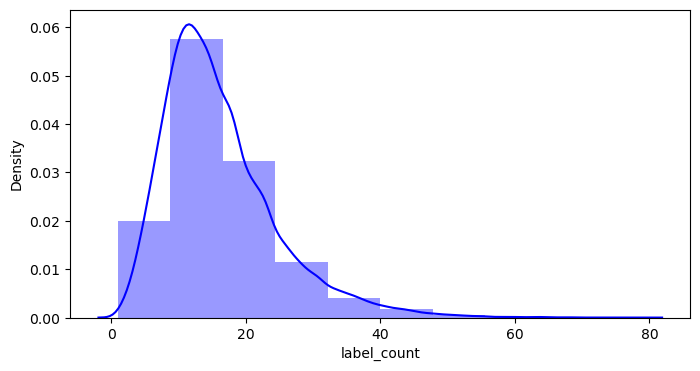

In [ ]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [ ]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [ ]:
lbls_sorted[:20]

[('401.9', 20053),
 ('38.93', 14444),
 ('428.0', 12842),
 ('427.31', 12594),
 ('414.01', 12179),
 ('96.04', 9932),
 ('96.6', 9161),
 ('584.9', 8907),
 ('250.00', 8784),
 ('96.71', 8619),
 ('272.4', 8504),
 ('518.81', 7249),
 ('99.04', 7147),
 ('39.61', 6809),
 ('599.0', 6442),
 ('530.81', 6156),
 ('96.72', 5926),
 ('272.0', 5766),
 ('285.9', 5296),
 ('88.56', 5240)]

In [ ]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#8922) ['401.9','38.93','428.0','427.31','414.01','96.04','96.6','584.9','250.00','96.71'...],
 (#8922) [20053,14444,12842,12594,12179,9932,9161,8907,8784,8619...])

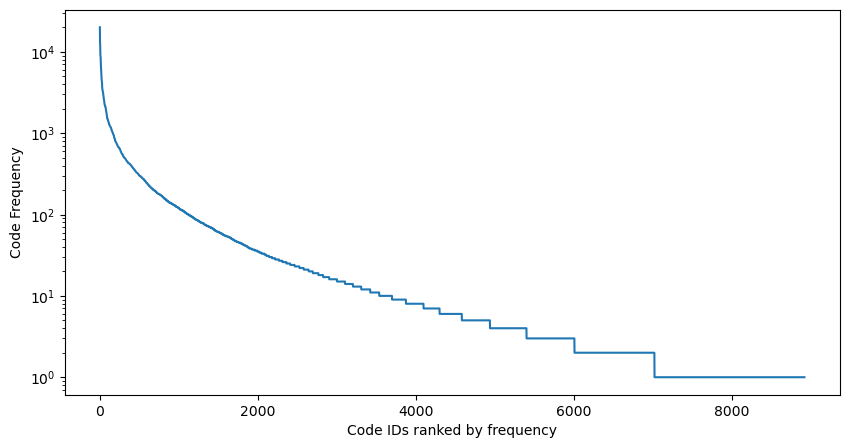

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Code IDs ranked by frequency')
ax.set_ylabel('Code Frequency')
ax.set_yscale('log');
fig.savefig('icd9_lbs_skew.pdf')

#### Check #4: Computing the min label freq for each text

In [ ]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [ ]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

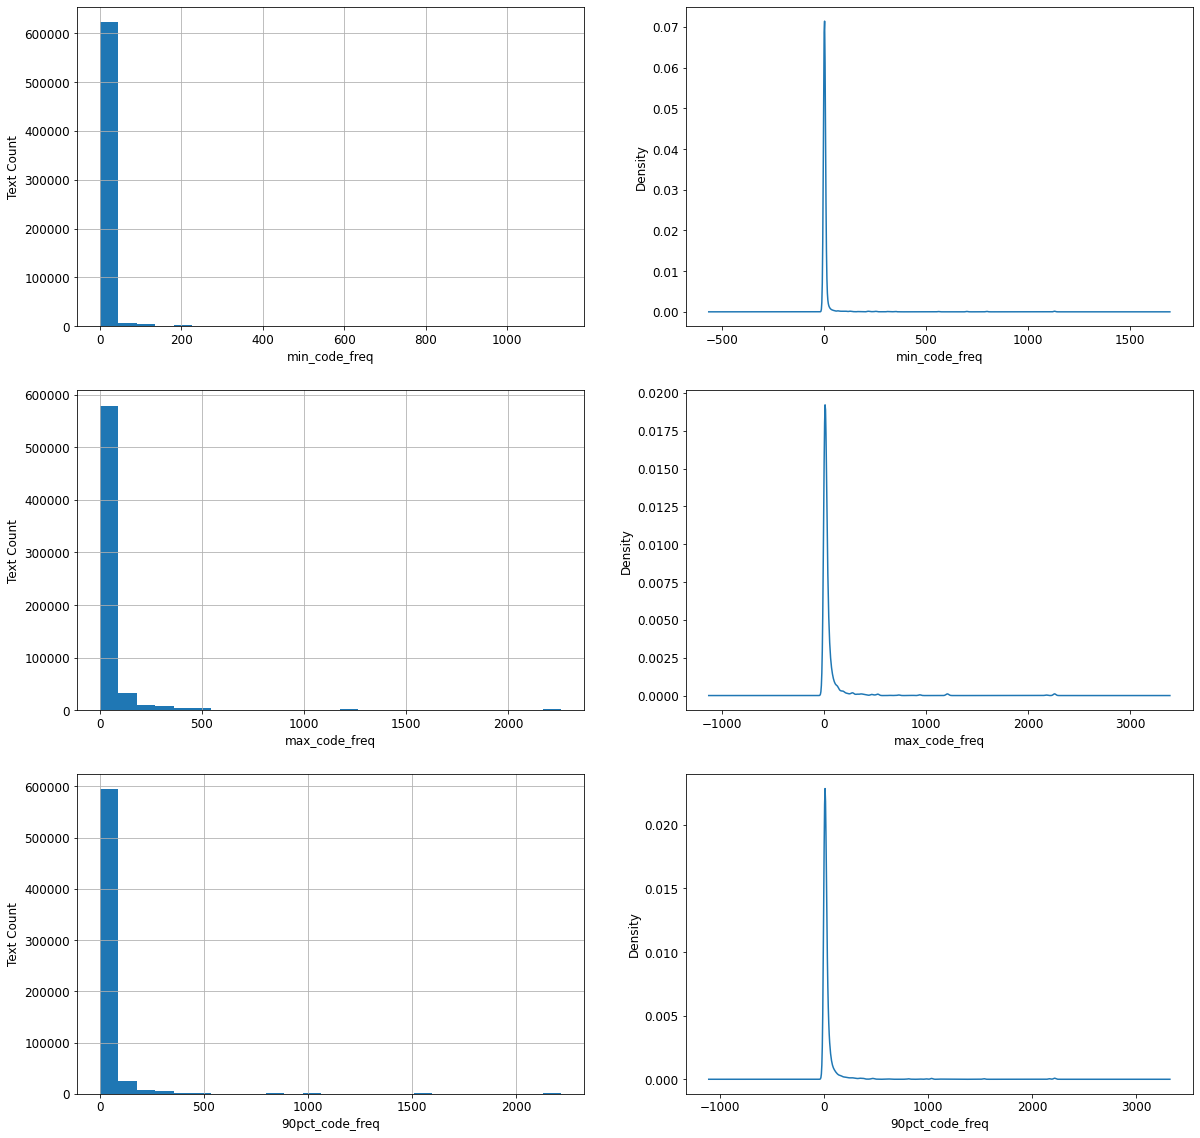

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [ ]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [ ]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [ ]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [ ]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

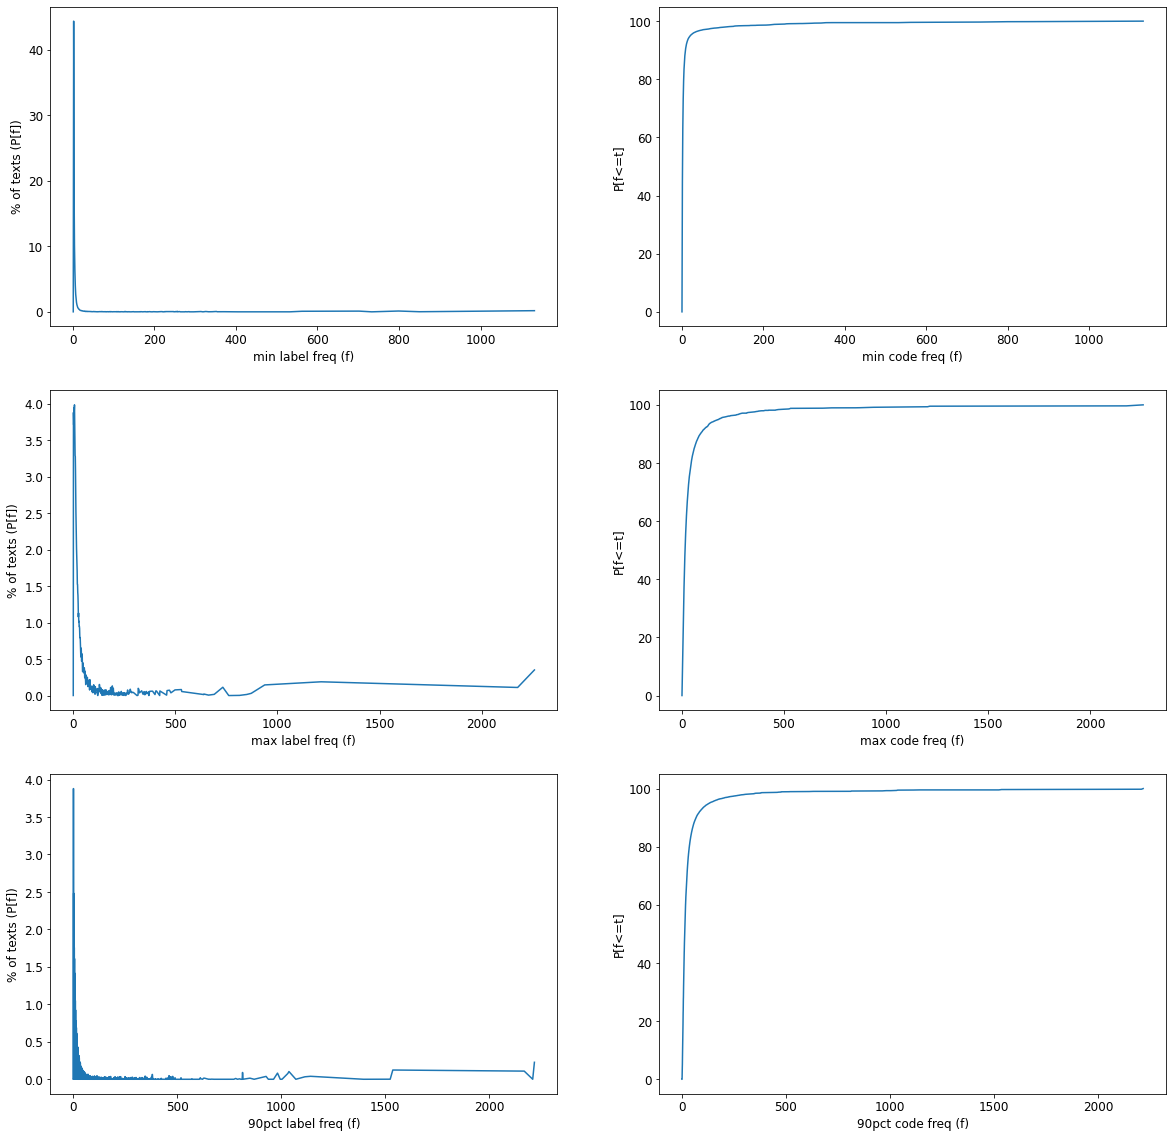

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(source/'mimic3-9k_dls_lm_vocab.pkl')
lm_vocab_r = torch.load(source/'mimic3-9k_dls_lm_vocab_r.pkl')

In [ ]:
all_equal(lm_vocab, lm_vocab_r)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
%%time
dsets = Datasets(df, tfms, splits=splits)

CPU times: user 17.9 s, sys: 3.27 s, total: 21.2 s
Wall time: 2min 38s


In [ ]:
%%time
dsets_r = Datasets(df, tfms_r, splits=splits)

CPU times: user 18.2 s, sys: 4.67 s, total: 22.9 s
Wall time: 2min 54s


Let's now check if our `Datasets` got created alright:

In [ ]:
len(dsets.train), len(dsets.valid)

(49354, 3372)

Let's check a random data point:

In [ ]:
idx = random.randint(0, len(dsets))
x = dsets.train[idx]
assert isinstance(x, tuple) # tuple if independent and dependent variable
x_r = dsets_r.train[idx]

In [ ]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex f service medicine allergies nsaids aspirin influenza virus vaccine attending first name3 lf chief complaint hypotension resp distress major surgical or invasive procedure rij placement and removal last name un gastric tube placement and removal rectal tube placement and removal picc line placement and removal history of present illness ms known lastname is a 50f with cirrhosis of unproven etiology h o perforated duodenal ulcer who has had weakness and back pain with cough and shortness of breath for days she has chronic low back pain but this is in a different location she also reports fever and chills she reports increasing weakness and fatigue over the same amount of time she is followed by vna who saw her at home and secondary to hypotension and hypoxia requested she go to ed in the ed initial vs were afebrile and o2 sat unable to be read ct of torso showed pneumonia but no abdominal pathology she was seen by surgery she was f

In [ ]:
dsets.show(x)

xxbos admission date discharge date date of birth sex f service medicine allergies nsaids aspirin influenza virus vaccine attending first name3 lf chief complaint hypotension resp distress major surgical or invasive procedure rij placement and removal last name un gastric tube placement and removal rectal tube placement and removal picc line placement and removal history of present illness ms known lastname is a 50f with cirrhosis of unproven etiology h o perforated duodenal ulcer who has had weakness and back pain with cough and shortness of breath for days she has chronic low back pain but this is in a different location she also reports fever and chills she reports increasing weakness and fatigue over the same amount of time she is followed by vna who saw her at home and secondary to hypotension and hypoxia requested she go to ed in the ed initial vs were afebrile and o2 sat unable to be read ct of torso showed pneumonia but no abdominal pathology she was seen by surgery she was fou

In [ ]:
assert isinstance(dsets.tfms[0], Pipeline) # `Pipeline` of the `x_tfms`
assert isinstance(dsets.tfms[0][0], Tokenizer)
assert isinstance(dsets.tfms[0][1], Transform)
assert isinstance(dsets.tfms[0][2], Numericalize)

If we just want to decode the one-hot encoded dependent variable:

In [ ]:
_ind, _dep = x
_lbl = dsets.tfms[1].decode(_dep)
test_eq(_lbl, array(lbls)[_dep.nonzero().flatten().int().numpy()])

Let's extract the `MultiCategorize` transform applied by `dsets` on the dependent variable so that we can apply it ourselves:

In [ ]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

`vocab` attribute of the `MultiCategorize` transform stores the category vocabulary. If it was specified from outside (in this case it was) then the `MultiCategorize` transform will not sort the vocabulary otherwise it will.

In [ ]:
test_eq(lbls, tfm_cat.vocab)
test_ne(lbls, sorted(tfm_cat.vocab))

In [ ]:
test_eq(str(_lbl.__class__), "<class 'fastai.data.transforms.MultiCategory'>")
test_eq(tfm_cat(_lbl), TensorMultiCategory([lbls.index(o) for o in _lbl]))
test_eq(tfm_cat.decode(tfm_cat(_lbl)), _lbl)

Let's check the reverse:

In [ ]:
# dsets_r.decode(x_r)

In [ ]:
# dsets_r.show(x_r)

Looks pretty good!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size (you might have to adjust this depending on you GPU size)

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so do save it when working on your dataset. In this though, (as always) `untar_xxx` downloaded it for you:

In [ ]:
!tree -shLD 1 {source} -P *clas*
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [192M May  1  2022]  mimic3-9k_clas.pth
├── [758K Mar 27 17:59]  mimic3-9k_clas_full_vocab.pkl
├── [1.6G Apr 21 18:29]  mimic3-9k_dls_clas.pkl
├── [1.6G Apr  5 17:17]  mimic3-9k_dls_clas_old_remove_later.pkl
├── [1.6G Apr 21 18:30]  mimic3-9k_dls_clas_r.pkl
└── [1.6G Apr  5 17:18]  mimic3-9k_dls_clas_r_old_remove_later.pkl

0 directories, 6 files


Aside: Some handy linux find tricks:
1. https://stackoverflow.com/questions/18312935/find-file-in-linux-then-report-the-size-of-file-searched
2. https://stackoverflow.com/questions/4210042/how-to-exclude-a-directory-in-find-command

In [ ]:
# !find -path ./models -prune -o -type f -name "*caml*" -exec du -sh {} \;
# !find -not -path "./data/*" -type f -name "*caml*" -exec du -sh {} \;
# !find {path_data} -type f -name "*caml*" | xargs du -sh

If you want to load the dls for the full dataset:

In [ ]:
%%time
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')
dls_clas_r = torch.load(source/'mimic3-9k_dls_clas_r.pkl')

CPU times: user 13.1 s, sys: 3.16 s, total: 16.2 s
Wall time: 16.6 s


Let's take a look at the data:

In [ ]:
# dls_clas.show_batch(max_n=3)

In [ ]:
# dls_clas_r.show_batch(max_n=3)

#### 4. (Optional) Making the `DataLoaders` using fastai's `DataBlock` API:

It's worth mentioning here that all the steps we performed to create the `DataLoaders` can be packaged together using fastai's `DataBlock` API. 

In [ ]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=sl, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
        dl_type = dl_type,
)

In [ ]:
dls_clas = dblock.dataloaders(df, bs=bs, before_batch=pad_input_chunk)

In [ ]:
dls_clas.show_batch(max_n=5)

## `Learner` for Multi-Label Classifier Fine-Tuning 

In [9]:
# set_seed(897997989, reproducible=True)
# set_seed(67, reproducible=True)
set_seed(1, reproducible=True)

This is where we have `dls_clas`(for the full dataset) we made in the previous section:

In [10]:
!tree -shDL 1 {source} -P "*clas*"
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [576M Jun  8 13:21]  mimic3-9k_clas_full.pth
├── [576M May 26 12:00]  mimic3-9k_clas_full_r.pth
├── [758K Mar 27 17:59]  mimic3-9k_clas_full_vocab.pkl
├── [1.6G Apr 21 18:29]  mimic3-9k_dls_clas.pkl
└── [1.6G Apr 21 18:30]  mimic3-9k_dls_clas_r.pkl

0 directories, 5 files


And this is where we have the finetuned language model:

In [11]:
!tree -shDL 1 {source} -P '*fine*'

/home/deb/.xcube/data/mimic3
├── [165M Apr 30  2022]  mimic3-9k_lm_finetuned.pth
└── [165M May  7  2022]  mimic3-9k_lm_finetuned_r.pth

0 directories, 2 files


And this is where we have the bootstrapped brain and the label biases:

In [12]:
!tree -shDL 1 {source_l2r} -P "*tok_lbl_info*|*p_L*"

/home/deb/.xcube/data/mimic3_l2r
├── [3.8G Jun 24  2022]  mimic3-9k_tok_lbl_info.pkl
└── [ 70K Apr  3 18:35]  p_L.pkl

0 directories, 2 files


Next we'll create a tmp directory to store results. In order for our learner to have access to the finetuned language model we need to symlink to it.

In [13]:
#| eval: false
tmp = Path.cwd()/'tmp/models'
tmp.mkdir(exist_ok=True, parents=True)
tmp = tmp.parent
# (tmp/'models'/'mimic3-9k_lm_decoder.pth').symlink_to(source/'mimic3-9k_lm_decoder.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_decoder_r.pth').symlink_to(source/'mimic3-9k_lm_decoder_r.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_finetuned.pth').symlink_to(source/'mimic3-9k_lm_finetuned.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_finetuned_r.pth').symlink_to(source/'mimic3-9k_lm_finetuned_r.pth') # run this just once
# (tmp/'models'/'mimic3-9k_tok_lbl_info.pkl').symlink_to(join_path_file('mimic3-9k_tok_lbl_info', source_l2r, ext='.pkl')) #run this just once
# (tmp/'models'/'p_L.pkl').symlink_to(join_path_file('p_L', source_l2r, ext='.pkl')) #run this just once
# (tmp/'models'/'lin_lambdarank_full.pth').symlink_to(join_path_file('lin_lambdarank_full', source_l2r, ext='.pth')) #run this just once
# list_files(tmp)
!tree -shD {tmp}

/home/deb/xcube/nbs/tmp
├── [1.0K Aug 23 23:32]  history_with_running.csv
├── [152M Mar  8 00:28]  lin_lambdarank_full.pth
├── [1.0M Mar  7 16:52]  lin_lambdarank_tiny.pth
├── [ 961 Aug 29 01:12]  mimic3-9k_clas_full_plant_lincomb.csv
├── [ 903 Aug 29 12:20]  mimic3-9k_clas_tiny_plant.csv
├── [ 936 Aug 28 20:07]  mimic3-9k_clas_top50_plant_k30.csv
├── [ 934 Aug 28 16:11]  mimic3-9k_clas_top50_plant_old.csv
├── [1.6G Aug 18 12:21]  mimic3-9k_dls_clas_16.pkl
├── [ 23G Feb 21  2023]  mimic3-9k_dls_clas_full.pkl
├── [2.4M Aug 28 11:34]  mimic3-9k_tiny.csv
├── [ 10M Aug 28 11:44]  mimic3-9k_tiny_dls_clas_16.pkl
├── [107M Aug 15 15:14]  mimic3-9k_top50.csv
├── [372M Aug 18 12:42]  mimic3-9k_top50_dls_clas_16.pkl
├── [4.0K Aug 28 20:57]  models
│   ├── [  56 Apr 17 17:29]  lin_lambdarank_full.pth -> /home/deb/.xcube/data/mimic3_l2r/lin_lambdarank_full.pth
│   ├── [  45 Jun 21 16:34]  lm_now_decoder.pth -> /home/deb/xcube/nbs/models/lm_now_decoder.pth
│   ├── [  47 Jun 21 16:33]  lm_now_finetu

Let's now get the dataloaders for the classifier. We'll also save classifier with `fname`.

In [14]:
fname="mimic3-9k_clas_tiny_plant"
dls_clas = torch.load(tmp/'mimic3-9k_tiny_dls_clas_16.pkl')

Let's create the saving callback upfront:

In [15]:
fname_r = fname+'_r'
cbs=SaveModelCallback(monitor='valid_precision_at_k', fname=fname, with_opt=True, reset_on_fit=True)
cbs_r=SaveModelCallback(monitor='valid_precision_at_k', fname=fname_r, with_opt=True, reset_on_fit=True)

We will make the `TextLearner` (Here you can use `pretrained=False` to save time beacuse we are anyway going to `load_encoder` later which will replace the encoder wgts with the ones we that we have in the fine-tuned LM):

Todo(Deb): Implement TTA
- make `max_len=None` during validation
- magnify important tokens

In [16]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                   pretrained=False,
                                   splitter=None,
                                   running_decoder=True
                                  ).to_fp16()

Note: Don't forget to check k in inattention

In [17]:
#| hide
# learn.model[0].__class__??
# learn.model[1].__class__??
# learn.model[1].pay_attn.__class__??

A few customizations into fastai's callbacks:

To tracks metrics on training bactches during an epoch:

In [18]:
# tell `Recorder` to track `train_metrics`
assert learn.cbs[1].__class__ is Recorder
setattr(learn.cbs[1], 'train_metrics', True)

In [19]:
# import copy
# mets = copy.deepcopy(learn.recorder._valid_mets)
# # mets = L(AvgSmoothLoss(), AvgMetric(precision_at_k))
# rv = RunvalCallback(mets)
# learn.add_cbs(rv)
# learn.cbs

In [20]:
@patch
def after_batch(self: ProgressCallback):
        self.pbar.update(self.iter+1)
        mets = ('_valid_mets', '_train_mets')[self.training]
        self.pbar.comment = ' '.join([f'{met.name} = {met.value.item():.4f}' for met in getattr(self.recorder, mets)])

The following line essentially captures the magic of [ULMFit's](https://arxiv.org/pdf/1801.06146.pdf) transfer learning:

In [21]:
learn = learn.load_encoder('mimic3-9k_lm_finetuned')

In [22]:
# learn = learn.load_brain('mimic3-9k_tok_lbl_info', 'p_L')
# learn = learn.load_diffntble_brain('mimic3-9k_tok_lbl_info', 'lin_lambdarank_full', 'mimic3-9k_lm_decoder')
# learn = learn.load_both('mimic3-9k_tok_lbl_info', 'p_L', 'lin_lambdarank_full', 'lm_now_decoder')

In [23]:
learn = learn.load_both('mimic3-9k_tok_lbl_info', 'p_L', 'lin_lambdarank_full', 'mimic3-9k_lm_decoder')
setattr(learn, 'splitter', awd_lstm_xclas_split)
learn.create_opt()

Performing static brainsplant...


Successfull!
Performing 'differentiable' brainsplant...


Successfull!


#### Check Splitter

Before:

In [ ]:
learn.model[0].module

AWD_LSTM(
  (encoder): Embedding(57376, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(57376, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0-2): 3 x RNNDropout()
  )
)

In [ ]:
learn.splitter??

Signature: learn.splitter(model)
Source:   
def awd_lstm_clas_split(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [nn.Sequential(model[0].module.encoder, model[0].module.encoder_dp)]
    groups += [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].module.rnns, model[0].module.hidden_dps)]
    groups = L(groups + [model[1]])
    return groups.map(params)
File:      ~/miniconda3/envs/deep/lib/python3.10/site-packages/fastai/text/models/awdlstm.py
Type:      function

In [ ]:
len(params(learn.model))

18

In [ ]:
# print('\n'.join(L(learn.model.named_parameters()).itemgot(0)))
for n,p in learn.model.named_parameters(): print(n, ":", p.shape)

0.module.encoder.weight : torch.Size([57376, 400])
0.module.rnns.0.weight_hh_l0_raw : torch.Size([4608, 1152])
0.module.rnns.0.module.weight_ih_l0 : torch.Size([4608, 400])
0.module.rnns.0.module.bias_ih_l0 : torch.Size([4608])
0.module.rnns.0.module.bias_hh_l0 : torch.Size([4608])
0.module.rnns.1.weight_hh_l0_raw : torch.Size([4608, 1152])
0.module.rnns.1.module.weight_ih_l0 : torch.Size([4608, 1152])
0.module.rnns.1.module.bias_ih_l0 : torch.Size([4608])
0.module.rnns.1.module.bias_hh_l0 : torch.Size([4608])
0.module.rnns.2.weight_hh_l0_raw : torch.Size([1600, 400])
0.module.rnns.2.module.weight_ih_l0 : torch.Size([1600, 1152])
0.module.rnns.2.module.bias_ih_l0 : torch.Size([1600])
0.module.rnns.2.module.bias_hh_l0 : torch.Size([1600])
0.decoder.label_bias : torch.Size([50])
0.decoder.pay_attn.plant : torch.Size([1])
0.decoder.pay_attn.lbs.weight : torch.Size([50, 400])
0.decoder.boost_attn.lin.weight : torch.Size([50, 400])
0.decoder.boost_attn.lin.bias : torch.Size([50])


In [ ]:
ic(len(learn.opt.param_lists));

ic| len(learn.opt.param_lists): 5


In [ ]:
groups = nn.Sequential(learn.model[0].module.encoder, learn.model[0].module.encoder_dp)
ic(len(params(groups)));
test_eq(params(groups), learn.opt.param_lists[0])
ic(len(learn.opt.param_lists[0]));
for n,p in groups.named_parameters(): print(n, "--", p)

ic| len(params(groups)): 1
ic| len(learn.opt.param_lists[0]): 1


0.weight -- Parameter containing:
tensor([[-0.0305,  0.0738, -0.0172,  ..., -0.0500, -0.1311,  0.0177],
        [-0.0040,  0.0021, -0.0021,  ..., -0.0055,  0.0038, -0.0010],
        [-0.2785, -0.1316,  0.1003,  ..., -0.1472,  0.1957, -0.1504],
        ...,
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018],
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018],
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018]])


In [ ]:
groups =  L(nn.Sequential(rnn, dp) for rnn, dp in zip(learn.model[0].module.rnns, learn.model[0].module.hidden_dps))
test_eq(learn.opt.param_lists[1:4], groups.map(params))
ic(len(groups));
ic(len(params(groups[2])));
for n,p in groups[2].named_parameters():
    print(n, "--", p)

ic| len(groups): 3
ic| len(params(groups[2])): 4


0.weight_hh_l0_raw -- Parameter containing:
tensor([[-0.0129,  0.0384, -0.0649,  ..., -0.0227, -0.0157,  0.0637],
        [-0.0576, -0.0571, -0.0784,  ..., -0.0432, -0.0607,  0.0439],
        [ 0.0191,  0.0201,  0.0348,  ...,  0.0592, -0.0246, -0.0244],
        ...,
        [-0.1034,  0.0303, -0.0232,  ..., -0.0777,  0.0356,  0.0284],
        [ 0.0443, -0.0297,  0.0717,  ...,  0.0195,  0.0319,  0.0063],
        [-0.0356, -0.0117,  0.0378,  ..., -0.0952, -0.0750, -0.1140]])
0.module.weight_ih_l0 -- Parameter containing:
tensor([[ 0.1752,  0.0122, -0.4035,  ...,  0.1798,  0.0779, -0.0835],
        [-0.0042,  0.1893,  0.0320,  ...,  0.0573, -0.5069,  0.1271],
        [-0.0662, -0.0492, -0.2105,  ..., -0.3303,  0.2351, -0.2733],
        ...,
        [ 0.2227, -0.1358,  0.1695,  ..., -0.0239, -0.1118,  0.3104],
        [ 0.0432, -0.4134,  0.0663,  ...,  0.0296,  0.2242,  0.0740],
        [ 0.2577, -0.3068, -0.1370,  ..., -0.5925,  0.2244, -0.0718]])
0.module.bias_ih_l0 -- Parameter containi

In [ ]:
test_eq(learn.opt.param_lists[4], params(learn.model[1]))
ic(len(params(learn.model[1])));
ic(len(learn.opt.param_lists[4]));
ic(learn.model[1]);
for n,p in learn.model[1].named_parameters():
    print(n, "--", p)

ic| len(params(learn.model[1])): 5
ic| len(learn.opt.param_lists[4]): 5
ic| learn.model[1]: LabelAttentionClassifier(
                      (pay_attn): XMLAttention(
                        (lbs): Embedding(50, 400)
                        (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
                      )
                      (boost_attn): ElemWiseLin(
                        (lin): Linear(in_features=400, out_features=50, bias=True)
                      )
                    )


label_bias -- Parameter containing:
tensor([-0.0982, -0.0723, -0.0125, -0.0984, -0.0900,  0.0990,  0.0700,  0.0801,
        -0.0213, -0.0859, -0.0237,  0.0122, -0.0288,  0.0962,  0.0659,  0.0496,
         0.0126, -0.0378,  0.0271, -0.0499,  0.0104, -0.0085, -0.0804, -0.0093,
         0.0195, -0.0795,  0.0184, -0.0444,  0.0993,  0.0959, -0.0362,  0.0953,
         0.0706, -0.0127,  0.0097,  0.0197, -0.0116,  0.0545, -0.0365, -0.0946,
         0.0006, -0.0665, -0.0212, -0.0495, -0.0499, -0.0039,  0.0898,  0.0991,
        -0.0258, -0.0472], requires_grad=True)
pay_attn.plant -- Parameter containing:
tensor([0.2853], requires_grad=True)
pay_attn.lbs.weight -- Parameter containing:
tensor([[-1.7395e-03,  3.1609e-04,  1.8310e-02,  ...,  1.0385e-02,
         -3.5329e-03,  1.2212e-02],
        [-1.7201e-03, -1.5629e-03, -1.6230e-03,  ...,  1.0942e-02,
          2.3167e-03,  1.1786e-02],
        [ 2.9426e-03,  3.0622e-03,  3.4067e-03,  ...,  1.5581e-03,
         -1.2304e-02,  4.3310e-03],
      

In [ ]:
learn.model[1]

LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(50, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=50, bias=True)
  )
)

After

In [ ]:
learn = learn.load_both('mimic3-9k_tok_lbl_info', 'p_L', 'lin_lambdarank_full', 'mimic3-9k_lm_decoder')

Performing static brainsplant...


Successfull!
Performing 'differentiable' brainsplant...


Successfull!


In [ ]:
awd_lstm_clas_split??

Signature: awd_lstm_clas_split(model)
Source:   
def awd_lstm_clas_split(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [nn.Sequential(model[0].module.encoder, model[0].module.encoder_dp)]
    groups += [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].module.rnns, model[0].module.hidden_dps)]
    groups = L(groups + [model[1]])
    return groups.map(params)
File:      ~/miniconda3/envs/deep/lib/python3.10/site-packages/fastai/text/models/awdlstm.py
Type:      function

In [ ]:
awd_lstm_xclas_split??

Signature: awd_lstm_xclas_split(model)
Source:   
def awd_lstm_xclas_split(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [nn.Sequential(model[0].module.encoder, model[0].module.encoder_dp)]
    groups += [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].module.rnns, model[0].module.hidden_dps)]
    return L(groups).map(params) + [params(model[1].pay_attn.lm_decoder)] + [params(model[1].pay_attn.l2r)] + L(model[1]).map(partial(_get_filter_params, but=re.compile('^(pay_attn.l2r|pay_attn.lm_decoder)')))
File:      ~/xcube/xcube/text/models/core.py
Type:      function

In [ ]:
setattr(learn, 'splitter', awd_lstm_xclas_split)
learn.create_opt()

In [ ]:
len(params(learn.model))

24

In [ ]:
len(learn.opt.param_lists)

7

The encoder remains the same:

In [ ]:
learn.opt.param_lists.map(len)

(#7) [1,4,4,4,2,4,5]

In [ ]:
groups = nn.Sequential(learn.model[0].module.encoder, learn.model[0].module.encoder_dp)
ic(len(params(groups)));
test_eq(params(groups), learn.opt.param_lists[0])
ic(len(learn.opt.param_lists[0]));
for n,p in groups.named_parameters(): print(n, "--", p)

ic| len(params(groups)): 1
ic| len(learn.opt.param_lists[0]): 1


0.weight -- Parameter containing:
tensor([[-0.0305,  0.0738, -0.0172,  ..., -0.0500, -0.1311,  0.0177],
        [-0.0040,  0.0021, -0.0021,  ..., -0.0055,  0.0038, -0.0010],
        [-0.2785, -0.1316,  0.1003,  ..., -0.1472,  0.1957, -0.1504],
        ...,
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018],
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018],
        [-0.0097,  0.0057, -0.0115,  ..., -0.0217,  0.0112, -0.0018]])


In [ ]:
groups =  L(nn.Sequential(rnn, dp) for rnn, dp in zip(learn.model[0].module.rnns, learn.model[0].module.hidden_dps))
test_eq(learn.opt.param_lists[1:4], groups.map(params))
ic(len(groups));
ic(len(params(groups[2])));
for n,p in groups[2].named_parameters():
    print(n, "--", p)

ic| len(groups): 3
ic| len(params(groups[2])): 4


0.weight_hh_l0_raw -- Parameter containing:
tensor([[-0.0129,  0.0384, -0.0649,  ..., -0.0227, -0.0157,  0.0637],
        [-0.0576, -0.0571, -0.0784,  ..., -0.0432, -0.0607,  0.0439],
        [ 0.0191,  0.0201,  0.0348,  ...,  0.0592, -0.0246, -0.0244],
        ...,
        [-0.1034,  0.0303, -0.0232,  ..., -0.0777,  0.0356,  0.0284],
        [ 0.0443, -0.0297,  0.0717,  ...,  0.0195,  0.0319,  0.0063],
        [-0.0356, -0.0117,  0.0378,  ..., -0.0952, -0.0750, -0.1140]])
0.module.weight_ih_l0 -- Parameter containing:
tensor([[ 0.1752,  0.0122, -0.4035,  ...,  0.1798,  0.0779, -0.0835],
        [-0.0042,  0.1893,  0.0320,  ...,  0.0573, -0.5069,  0.1271],
        [-0.0662, -0.0492, -0.2105,  ..., -0.3303,  0.2351, -0.2733],
        ...,
        [ 0.2227, -0.1358,  0.1695,  ..., -0.0239, -0.1118,  0.3104],
        [ 0.0432, -0.4134,  0.0663,  ...,  0.0296,  0.2242,  0.0740],
        [ 0.2577, -0.3068, -0.1370,  ..., -0.5925,  0.2244, -0.0718]])
0.module.bias_ih_l0 -- Parameter containi

The decoder:

In [ ]:
learn.model[1]

LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(50, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
    (plant_attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
    (l2r): ModuleDict(
      (token_factors): Embedding(57376, 200)
      (token_bias): Embedding(57376, 1)
      (label_factors): Embedding(50, 200)
      (label_bias): Embedding(50, 1)
    )
    (lin_attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
    (lm_decoder): PlantedLMDecoder(
      (decoder): Linear(in_features=400, out_features=57376, bias=True)
      (output_dp): RNNDropout()
    )
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=50, bias=True)
  )
)

The real decoder layers are `learn.opt.param_lists[-1]`

In [ ]:
len(learn.opt.param_lists[-1])

5

In [ ]:
test_eq(learn.opt.param_lists[-1][0], learn.model[1].label_bias) 
assert learn.opt.param_lists[-1][0] is learn.model[1].label_bias

test_eq(learn.opt.param_lists[-1][1], learn.model[1].pay_attn.plant)
assert learn.opt.param_lists[-1][1] is learn.model[1].pay_attn.plant


test_eq(learn.opt.param_lists[-1][2], learn.model[1].pay_attn.lbs.weight)
assert learn.opt.param_lists[-1][2] is  learn.model[1].pay_attn.lbs.weight
    
test_eq(learn.opt.param_lists[-1][3], learn.model[1].boost_attn.lin.weight)
assert learn.opt.param_lists[-1][3] is  learn.model[1].boost_attn.lin.weight
    
test_eq(learn.opt.param_lists[-1][4], learn.model[1].boost_attn.lin.bias)
assert learn.opt.param_lists[-1][4] is  learn.model[1].boost_attn.lin.bias

The planted l2r is `learn.opt.param_lists[-2]`:

In [ ]:
test_eq(learn.opt.param_lists[-2][0], learn.model[1].pay_attn.l2r.token_factors.weight)
learn.opt.param_lists[-2][0] is learn.model[1].pay_attn.l2r.token_factors.weight

test_eq(learn.opt.param_lists[-2][1], learn.model[1].pay_attn.l2r.token_bias.weight)
learn.opt.param_lists[-2][1] is learn.model[1].pay_attn.l2r.token_bias.weight

test_eq(learn.opt.param_lists[-2][2], learn.model[1].pay_attn.l2r.label_factors.weight)
learn.opt.param_lists[-2][2] is learn.model[1].pay_attn.l2r.label_factors.weight

test_eq(learn.opt.param_lists[-2][3], learn.model[1].pay_attn.l2r.label_bias.weight)
learn.opt.param_lists[-2][3] is learn.model[1].pay_attn.l2r.label_bias.weight

True

The lm_decoder is `learn.opt.param_lists[-3]`

In [ ]:
test_eq(learn.opt.param_lists[-3][0], learn.model[1].pay_attn.lm_decoder.decoder.weight)
learn.opt.param_lists[-3][0] is learn.model[1].pay_attn.lm_decoder.decoder.weight

test_eq(learn.opt.param_lists[-3][1], learn.model[1].pay_attn.lm_decoder.decoder.bias)
learn.opt.param_lists[-3][1] is learn.model[1].pay_attn.lm_decoder.decoder.bias

True

In [ ]:
class _FakeLearner: 
    def to_detach(self,b,cpu=True,gather=True):
        return to_detach(b,cpu,gather)
_fake_l = _FakeLearner()

def cpupy(t): return t.cpu().numpy() if isinstance(t, Tensor) else t
learn.model = learn.model.to('cuda:0')

TODO:
- Also print avg text lengths

In [ ]:
# import copy
# mets = L(AvgLoss(), AvgMetric(partial(precision_at_k, k=15)))
mets = L(F1ScoreMulti(thresh=0.14, average='macro'), F1ScoreMulti(thresh=0.14, average='micro'))  #(learn.recorder._valid_mets)
learn.model.eval()
mets.map(Self.reset())
pbar = progress_bar(learn.dls.valid)
log_file = join_path_file('log', learn.path/learn.model_dir, ext='.csv')
with open(log_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    header = mets.attrgot('name') + L('bs', 'n_lbs', 'mean_nlbs')
    writer.writerow(header)
    for i, (xb, yb) in enumerate(pbar):
        _fake_l.yb = (yb,)
        _fake_l.y = yb
        _fake_l.pred, *_ = learn.model(xb) 
        _fake_l.loss = Tensor(learn.loss_func(_fake_l.pred, yb))
        for met in mets: met.accumulate(_fake_l)
        pbar.comment = ' '.join(mets.attrgot('value').map(str))
        yb_nlbs =  Tensor(yb.count_nonzero(dim=1)).float().cpu().numpy()
        writer.writerow(mets.attrgot('value').map(cpupy) + L(find_bs(yb), yb_nlbs, yb_nlbs.mean()))

In [ ]:
pd.set_option('display.max_rows', 100)
df = pd.read_csv(log_file)
df

In [ ]:
# learn.model[1].label_bias.data.min(),  learn.model[1].label_bias.data.max()
# nn.init.kaiming_normal_(learn.model[1].label_bias.data.unsqueeze(-1))
# # init_default??
# with torch.no_grad(): 
    # learn.model[1].label_bias.data = learn.lbsbias
# learn.model[1].label_bias.data.min(),  learn.model[1].label_bias.data.max()
# learn.model[1].pay_attn.attn.func.f#, learn_r.model[1].pay_attn.attn.func.f
# set_seed(1, reproducible=True)

## Dev (Ignore)

In [ ]:
df_des = pd.read_csv(source/'code_descriptions.csv')

In [ ]:
learn = learn.load_brain('mimic3-9k_tok_lbl_info')
learn.brain.shape

Performing brainsplant...


Successfull!


torch.Size([57376, 1271])

In [ ]:
L(learn.dls.vocab[0]), L(learn.dls.vocab[1])

((#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#1271) ['431','507.0','518.81','112.0','287.4','401.9','427.89','600.00','272.4','300.4'...])

In [ ]:
rnd_code = '733.00' #random.choice(learn.dls.vocab[1]) # '96.04'
des = load_pickle(join_path_file('code_desc', source, ext='.pkl'))
k=20
idx, *_ = dls_clas.vocab[1].map_objs([rnd_code])
print(f"For the icd code {rnd_code} which means {des[rnd_code]}, the top {k} tokens in the brain are:")
print('\n'.join(L(array(learn.dls.vocab[0])[learn.brain[:, idx].topk(k=k).indices.cpu()], use_list=True)))

For the icd code 733.00 which means Osteoporosis, unspecified, the top 20 tokens in the brain are:
osteoporosis
fosamax
alendronate
d3
carbonate
cholecalciferol
70
osteoperosis
actonel
she
her
he
his
vitamin
risedronate
qweek
compression
raloxifene
ms
male


Let's pull out a text from the batch and take a look at the text and its codes:

In [ ]:
xb, yb = dls_clas.one_batch()
i = 3
text = ' '.join([dls_clas.vocab[0][o] for o in xb[3] if o !=1])
codes = dls_clas.tfms[1].decode(yb[3])
print(f"The text is {len(text)} words long and has {len(codes)} codes")

The text is 25411 words long and has 36 codes


In [ ]:
df_codes = pd.DataFrame(columns=['code', 'description', 'freq', 'top_toks'])
df_codes['code'] = codes
df_codes['description'] = mapt(des.get, codes)
df_codes['freq'] = mapt(lbl_freqs.get, codes)
idxs = learn.dls.vocab[1].map_objs(codes)
top_toks = array(learn.dls.vocab[0])[learn.brain[:, idxs].topk(k=k, dim=0).indices.cpu()].T
top_vals = learn.brain[:, idxs].topk(k=k, dim=0).values.cpu().T
df_codes['top_toks'] = L(top_toks, use_list=True).map(list)
df_codes

,code,description,freq,top_toks
0,507.0,Pneumonitis due to inhalation of food or vomitus,15,"[aspiration, pneumonia, pneumonitis, pna, flagyl, swallow, peg, sputum, intubation, secretions, levofloxacin, aspirated, suctioning, video, hypoxic, opacities, tube, zosyn, hypoxia, vancomycin]"
1,518.81,Acute respiratory failure,42,"[intubation, intubated, peep, failure, respiratory, fio2, hypoxic, extubation, sputum, pneumonia, sedated, abg, endotracheal, hypercarbic, expired, vent, hypoxia, pco2, aspiration, vancomycin]"
2,96.04,Insertion of endotracheal tube,48,"[intubated, intubation, extubation, surfactant, extubated, endotracheal, respiratory, peep, sedated, airway, ventilator, ventilation, protection, fio2, reintubated, tube, expired, vent, feeds, et]"
3,96.72,Continuous mechanical ventilation for 96 consecutive hours or more,35,"[intubated, tracheostomy, ventilator, trach, vent, intubation, tube, sputum, peg, peep, extubation, ventilation, wean, feeds, secretions, bal, sedated, weaning, fio2, reintubated]"
4,99.15,Parenteral infusion of concentrated nutritional substances,22,"[tpn, nutrition, parenteral, prematurity, phototherapy, feeds, hyperbilirubinemia, immunizations, preterm, circumference, enteral, newborn, pediatrician, infant, caffeine, prenatal, infants, rubella, surfactant, percentile]"
5,38.93,"Venous catheterization, not elsewhere classified",77,"[picc, line, vancomycin, central, zosyn, cultures, grew, placement, flagyl, vanco, tpn, septic, recon, placed, flush, levophed, bacteremia, intubated, ij, soln]"
6,785.52,Septic shock,17,"[septic, shock, levophed, pressors, sepsis, hypotension, zosyn, vasopressin, hypotensive, myelos, meropenem, broad, metas, atyps, expired, pressor, spectrum, urosepsis, vancomycin, vanc]"
7,995.92,Severe sepsis,23,"[septic, shock, sepsis, levophed, pressors, hypotension, zosyn, meropenem, expired, vancomycin, myelos, metas, atyps, vanco, bacteremia, vanc, broad, hypotensive, cefepime, spectrum]"
8,518.0,Pulmonary collapse,9,"[collapse, atelectasis, bronchoscopy, bronchus, plugging, plug, lobe, collapsed, bronch, pleural, secretions, spirometry, thoracentesis, incentive, newborn, rubella, infant, immunizations, hemithorax, pediatrician]"
9,584.9,"Acute renal failure, unspecified",49,"[renal, arf, failure, cr, prerenal, baseline, creatinine, kidney, medicine, acute, likely, setting, elevated, held, urine, cxr, ed, infant, chf, improved]"


In [ ]:
print('\n'.join(L(zip(top_toks[16], top_vals[16])).map(str)))

('osteoporosis', tensor(0.3675))
('fosamax', tensor(0.0482))
('alendronate', tensor(0.0479))
('d3', tensor(0.0223))
('carbonate', tensor(0.0183))
('cholecalciferol', tensor(0.0181))
('70', tensor(0.0147))
('osteoperosis', tensor(0.0137))
('actonel', tensor(0.0132))
('she', tensor(0.0128))
('her', tensor(0.0127))
('he', tensor(0.0109))
('his', tensor(0.0095))
('vitamin', tensor(0.0092))
('risedronate', tensor(0.0078))
('qweek', tensor(0.0077))
('compression', tensor(0.0076))
('raloxifene', tensor(0.0070))
('ms', tensor(0.0069))
('male', tensor(0.0067))


In [ ]:
tok_list = top_toks[16]
L(tok for tok in tok_list if tok in text.split())

(#5) ['osteoporosis','he','his','vitamin','male']

In [ ]:
pattern = r'\b({0})\b'.format('|'.join(list(tok_list)))
pattern = re.compile(pattern)
for i,match in enumerate(pattern.finditer(text)):
    print(i, match.group())
    print("-"*len(match.group()))
    print(text[match.start()-100: match.end()+100], end='\n\n')

0 diabetes
--------
vement in numbers no episodes of bleeding dic labs negative he subsequent had platelets in 60s 100s diabetes the patient was placed on ssi in house and lantus due to persistent hypoglycemia in the morning he 

1 insulin
-------
mnia oxycodone mg tablet sig one tablet po q6h every hours as needed for pain disp tablet s refills insulin glargine unit ml solution sig twelve units subcutaneous at bedtime heparin flush units ml ml iv prn

2 diabetes
--------
 failure atrial fibrillation with rapid ventricular response portal gastropathy secondary cirrhosis diabetes mellitus discharge condition mental status clear and coherent level of consciousness alert and inte

3 mellitus
--------
atrial fibrillation with rapid ventricular response portal gastropathy secondary cirrhosis diabetes mellitus discharge condition mental status clear and coherent level of consciousness alert and interactive a



In [ ]:
tst_model = get_xmltext_classifier2(AWD_LSTM, 60000, 1271, seq_len=72, config=awd_lstm_clas_config, 
                               drop_mult=0.1, max_len=72*40).to(default_device())

xb, yb = dls_clas.one_batch()

L(xb, yb).map(lambda o: (o.shape, o.device))

sent_enc = learn.model[0].to(default_device())
attn_clas = learn.model[1].to(default_device())

preds_by_sent_enc, mask = sent_enc(xb)
preds_by_sent_enc.shape, mask.shape

o = tst_model(xb)

o[0].shape

tst_model[1].hl.shape

## Fine-Tuning the Classifier 

In [ ]:
learn.fit(2, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006671,0.427560,0.007373,0.501760,18:52
1,0.006010,0.486638,0.007033,0.518841,19:13


In [ ]:
learn.fit(9, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006171,0.496154,0.006873,0.524792,19:04
1,0.006296,0.499897,0.006786,0.526097,19:07
2,0.006071,0.501944,0.006728,0.529656,21:40
3,0.005868,0.503599,0.006685,0.529261,19:53
4,0.005772,0.504341,0.006666,0.530565,18:51
5,0.005700,0.504796,0.006648,0.529201,19:29
6,0.005662,0.504856,0.006632,0.530625,18:40
7,0.006080,0.505080,0.006594,0.531870,19:07
8,0.005849,0.505091,0.006607,0.532543,18:40


Path('/home/deb/xcube/nbs/tmp/models/mimic_tmp.pth')

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(10, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004908,0.520075,0.005996,0.554903,22:30
1,0.005100,0.524777,0.005895,0.557651,22:42
2,0.004864,0.525998,0.005869,0.555219,23:00
3,0.004873,0.527586,0.005766,0.561507,22:30
4,0.004755,0.530503,0.005780,0.558323,22:37
5,0.004760,0.532162,0.005718,0.562060,22:37
6,0.004906,0.533651,0.005617,0.569632,22:28
7,0.004725,0.535399,0.005622,0.569553,23:41
8,0.004727,0.536854,0.005613,0.569968,22:40
9,0.004670,0.538211,0.005558,0.571372,23:04


Path('/home/deb/xcube/nbs/tmp/models/mimic2_tmp.pth')

In [ ]:
learn.fit(10, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004632,0.539177,0.005528,0.571847,22:36
1,0.004653,0.540667,0.005551,0.568802,22:27
2,0.004833,0.541256,0.005607,0.566588,24:31
3,0.004460,0.541850,0.005555,0.573665,26:17
4,0.004692,0.540970,0.005530,0.570522,23:43
5,0.004859,0.541696,0.005493,0.574812,22:50
6,0.004495,0.543965,0.005538,0.570364,22:46
7,0.004517,0.544347,0.005493,0.572875,23:18
8,0.004755,0.543222,0.005501,0.572578,23:29
9,0.004687,0.544784,0.005483,0.571076,22:44


Path('/home/deb/xcube/nbs/tmp/models/mimic3_tmp.pth')

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(2, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004854,0.550886,0.005433,0.578094,1:09:40
1,0.004290,0.554642,0.005335,0.582720,1:13:00


Path('/home/deb/xcube/nbs/tmp/models/mimic4_tmp.pth')

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004555,0.558910,0.005358,0.583887,1:08:32
1,0.004249,0.559825,0.005338,0.582068,1:06:38
2,0.004497,0.557554,0.005273,0.588711,1:08:03
3,0.004690,0.557821,0.005338,0.582444,1:04:41
4,0.004420,0.559116,0.005297,0.585923,1:04:19


Better model found at epoch 0 with valid_precision_at_k value: 0.5838869118228547.
Better model found at epoch 2 with valid_precision_at_k value: 0.5887109529458283.


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004274,0.571029,0.005253,0.589897,1:22:37
1,0.003970,0.573214,0.005237,0.590826,1:35:24
2,0.003580,0.576061,0.005224,0.592210,1:28:15
3,0.004398,0.573131,0.005213,0.592764,1:21:15
4,0.004146,0.573926,0.005203,0.593634,1:21:23
5,0.004096,0.575295,0.005194,0.594227,1:20:27
6,0.004011,0.575432,0.005185,0.594879,1:20:34
7,0.003997,0.576225,0.005178,0.595789,1:23:31
8,0.003942,0.577274,0.005171,0.596362,1:21:20
9,0.004266,0.577674,0.005164,0.596659,1:21:25


Better model found at epoch 0 with valid_precision_at_k value: 0.5898971925662319.
Better model found at epoch 1 with valid_precision_at_k value: 0.5908264136022148.
Better model found at epoch 2 with valid_precision_at_k value: 0.5922103598260184.
Better model found at epoch 3 with valid_precision_at_k value: 0.59276393831554.
Better model found at epoch 4 with valid_precision_at_k value: 0.5936338473705026.
Better model found at epoch 5 with valid_precision_at_k value: 0.594226967180704.
Better model found at epoch 6 with valid_precision_at_k value: 0.5948793989719259.
Better model found at epoch 7 with valid_precision_at_k value: 0.5957888493475683.
Better model found at epoch 8 with valid_precision_at_k value: 0.59636219849743.
Better model found at epoch 9 with valid_precision_at_k value: 0.5966587584025307.
Better model found at epoch 10 with valid_precision_at_k value: 0.5971134835903521.
Better model found at epoch 11 with valid_precision_at_k value: 0.5972321075523922.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004173,0.580595,0.005147,0.597628,1:27:59
1,0.003887,0.581874,0.005142,0.598082,1:26:58
2,0.003538,0.584128,0.005137,0.598280,1:25:40
3,0.004319,0.580220,0.005133,0.598557,1:22:04
4,0.004077,0.580681,0.005128,0.598754,1:29:05
5,0.004035,0.581153,0.005124,0.599229,1:23:48
6,0.003955,0.581074,0.005120,0.599644,1:27:02
7,0.003943,0.581586,0.005117,0.599960,1:25:09
8,0.003891,0.582050,0.005113,0.600138,1:25:04
9,0.004217,0.582461,0.005110,0.600178,1:32:48


Better model found at epoch 0 with valid_precision_at_k value: 0.5976275207591935.
Better model found at epoch 1 with valid_precision_at_k value: 0.5980822459470149.
Better model found at epoch 2 with valid_precision_at_k value: 0.5982799525504153.
Better model found at epoch 3 with valid_precision_at_k value: 0.5985567417951758.
Better model found at epoch 4 with valid_precision_at_k value: 0.5987544483985765.
Better model found at epoch 5 with valid_precision_at_k value: 0.5992289442467379.
Better model found at epoch 6 with valid_precision_at_k value: 0.5996441281138793.
Better model found at epoch 7 with valid_precision_at_k value: 0.5999604586793202.
Better model found at epoch 8 with valid_precision_at_k value: 0.6001383946223807.
Better model found at epoch 9 with valid_precision_at_k value: 0.6001779359430608.
Better model found at epoch 10 with valid_precision_at_k value: 0.6008105970739425.
Better model found at epoch 11 with valid_precision_at_k value: 0.601008303677343.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004131,0.584655,0.005100,0.601364,1:27:13
1,0.003851,0.585673,0.005098,0.601522,1:27:38
2,0.003534,0.587853,0.005095,0.601839,1:27:55
3,0.004281,0.583691,0.005092,0.602096,1:26:51
4,0.004044,0.584044,0.005090,0.602135,1:23:44
5,0.004004,0.584326,0.005088,0.602550,1:25:08
6,0.003927,0.584212,0.005085,0.602669,1:28:46
7,0.003916,0.584371,0.005083,0.602748,1:35:59
8,0.003863,0.584690,0.005081,0.603005,1:32:43
9,0.004190,0.585073,0.005079,0.603203,1:35:33


Better model found at epoch 0 with valid_precision_at_k value: 0.601364175563464.
Better model found at epoch 1 with valid_precision_at_k value: 0.6015223408461846.
Better model found at epoch 2 with valid_precision_at_k value: 0.6018386714116253.
Better model found at epoch 3 with valid_precision_at_k value: 0.6020956899960457.
Better model found at epoch 4 with valid_precision_at_k value: 0.6021352313167257.
Better model found at epoch 5 with valid_precision_at_k value: 0.6025504151838669.
Better model found at epoch 6 with valid_precision_at_k value: 0.6026690391459072.
Better model found at epoch 7 with valid_precision_at_k value: 0.6027481217872676.
Better model found at epoch 8 with valid_precision_at_k value: 0.6030051403716885.
Better model found at epoch 9 with valid_precision_at_k value: 0.603202846975089.
Better model found at epoch 10 with valid_precision_at_k value: 0.6034005535784894.
Better model found at epoch 11 with valid_precision_at_k value: 0.6038157374456307.


In [ ]:
learn.fit(17, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004109,0.586924,0.005073,0.603934,1:30:05
1,0.003831,0.587917,0.005072,0.604053,1:27:47
2,0.003542,0.589895,0.005070,0.604013,1:27:51
3,0.004260,0.585822,0.005069,0.603895,1:28:24
4,0.004025,0.586037,0.005067,0.603855,1:28:43
5,0.003987,0.586026,0.005066,0.604172,1:27:41
6,0.003912,0.586035,0.005064,0.604290,1:25:56
7,0.003901,0.586076,0.005063,0.604409,1:27:44
8,0.003848,0.586360,0.005061,0.604389,1:25:51
9,0.004176,0.586516,0.005060,0.604350,1:25:42


Better model found at epoch 0 with valid_precision_at_k value: 0.603934361407671.
Better model found at epoch 1 with valid_precision_at_k value: 0.6040529853697115.
Better model found at epoch 5 with valid_precision_at_k value: 0.6041716093317517.
Better model found at epoch 6 with valid_precision_at_k value: 0.6042902332937922.
Better model found at epoch 7 with valid_precision_at_k value: 0.6044088572558325.
Better model found at epoch 11 with valid_precision_at_k value: 0.6045077105575327.
Better model found at epoch 12 with valid_precision_at_k value: 0.6047449584816134.
Better model found at epoch 13 with valid_precision_at_k value: 0.6049228944246741.
Better model found at epoch 14 with valid_precision_at_k value: 0.6050810597073943.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004095,0.588552,0.005054,0.604982,1:27:02
1,0.003819,0.589632,0.005053,0.605081,1:23:54
2,0.003560,0.591372,0.005052,0.605397,1:23:37
3,0.004247,0.587154,0.005051,0.605417,1:24:47
4,0.004014,0.587362,0.005050,0.605575,1:25:40
5,0.003976,0.587346,0.005050,0.605595,1:25:16
6,0.003904,0.587354,0.005049,0.605516,1:30:16
7,0.003893,0.587376,0.005048,0.605575,1:23:22
8,0.003840,0.587661,0.005048,0.605556,1:27:31
9,0.004168,0.587554,0.005047,0.605753,1:27:43


Better model found at epoch 1 with valid_precision_at_k value: 0.6050810597073941.
Better model found at epoch 2 with valid_precision_at_k value: 0.6053973902728351.
Better model found at epoch 3 with valid_precision_at_k value: 0.6054171609331752.
Better model found at epoch 4 with valid_precision_at_k value: 0.6055753262158957.
Better model found at epoch 5 with valid_precision_at_k value: 0.6055950968762357.
Better model found at epoch 9 with valid_precision_at_k value: 0.6057532621589561.
Better model found at epoch 10 with valid_precision_at_k value: 0.6057928034796363.
Better model found at epoch 11 with valid_precision_at_k value: 0.6059311981020166.


start here:

In [ ]:
print(learn.save_model.fname)
learn.save_model.reset_on_fit=False
assert not learn.save_model.reset_on_fit
learn = learn.load(learn.save_model.fname)
validate(learn)

mimic3-9k_clas_full
best so far = None


[0.00504577299579978, 0.6059311981020166]
best so far = None


In [ ]:
learn.save_model.best = 0.605931198

Now unfreeze and train more if you want:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004091,0.589346,0.005045,0.605832,1:26:58
1,0.003816,0.590275,0.005045,0.605872,1:39:14
2,0.003580,0.591960,0.005044,0.605971,1:24:25
3,0.004243,0.587718,0.005044,0.606030,1:29:50
4,0.004012,0.587808,0.005044,0.606168,1:26:04
5,0.003974,0.587973,0.005043,0.606070,1:25:14
6,0.003903,0.587727,0.005043,0.605991,1:25:52
7,0.003892,0.587734,0.005043,0.606010,1:30:01
8,0.003839,0.588023,0.005042,0.606010,1:27:09
9,0.004167,0.588038,0.005042,0.606070,1:27:05


Better model found at epoch 2 with valid_precision_at_k value: 0.6059707394226967.
Better model found at epoch 3 with valid_precision_at_k value: 0.6060300514037169.
Better model found at epoch 4 with valid_precision_at_k value: 0.6061684460260972.


---

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

as defined here in [ULMFit](https://arxiv.org/pdf/1801.06146.pdf)

If we are using the `LabelForcing` callback, then the loss will spike after certain number of epochs. So we need to remove this callback before doing `lr_find`. This is because `lr_find` aborts if things go south with regard to loss. 

lr_min=0.03156457841396332, lr_steep=6.867521165077051e-07, lr_valley=0.016935577616095543, lr_slide=9.255502700805664


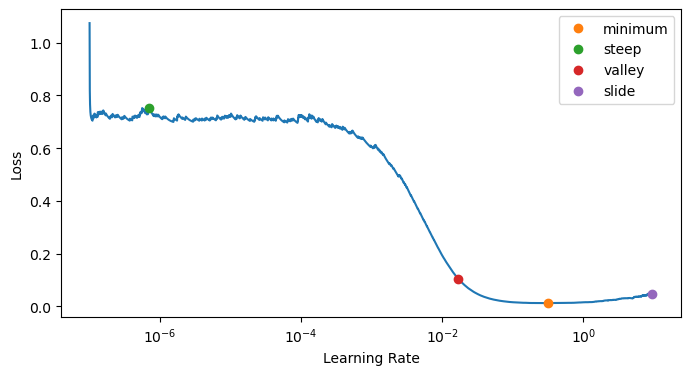

In [ ]:
lbl_fcr = None
with suppress(ValueError): lbl_fcr = learn.cbs[learn.cbs.map(type).index(LabelForcing)]
with learn.removed_cbs(lbl_fcr):
    lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), num_it=5000)
    print(f"{lr_min=}, {lr_steep=}, {lr_valley=}, {lr_slide=}")

In [ ]:
# learn.opt.hypers.map(lambda d: d['lr'])

In [ ]:
[0.14*i/4 for i in range(4, 0, -1)], [0.14*i for i in range(4, 0, -1)], 

([0.14, 0.10500000000000001, 0.07, 0.035],
 [0.56, 0.42000000000000004, 0.28, 0.14])

In [ ]:
learn.cbs[-4].reset_on_fit = False
assert not learn.cbs[-4].reset_on_fit
# for i in range(4, 0, -1):
#     learn.fit_one_cycle(1, lr_max=0.14*i, moms=(0.8,0.7,0.8), wd=0.1)
#     learn.fit_one_cycle(5, lr_max=0.14*i, moms=(0.8,0.7,0.8), wd=0.1)
learn.fit_sgdr(4, 1, lr_max=0.2, wd=0.1)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.356484,0.171389,0.237203,0.260000,00:14
1,0.235747,0.370000,0.124639,0.366667,00:12
2,0.172845,0.487500,0.117452,0.390000,00:12
3,0.140756,0.489444,0.102276,0.423333,00:13
4,0.118405,0.546667,0.096350,0.430000,00:13
5,0.102951,0.585556,0.093344,0.443333,00:12
6,0.091534,0.616111,0.092173,0.436667,00:12
7,0.084460,0.586389,0.085513,0.426667,00:12
8,0.078414,0.589722,0.082874,0.446667,00:11
9,0.073319,0.594444,0.085145,0.423333,00:12


Better model found at epoch 0 with valid_precision_at_k value: 0.26.
Better model found at epoch 1 with valid_precision_at_k value: 0.36666666666666664.
Better model found at epoch 2 with valid_precision_at_k value: 0.39.
Better model found at epoch 3 with valid_precision_at_k value: 0.42333333333333334.
Better model found at epoch 4 with valid_precision_at_k value: 0.43.
Better model found at epoch 5 with valid_precision_at_k value: 0.44333333333333336.
Better model found at epoch 8 with valid_precision_at_k value: 0.44666666666666666.
Better model found at epoch 10 with valid_precision_at_k value: 0.4633333333333334.
Better model found at epoch 11 with valid_precision_at_k value: 0.4666666666666666.
Better model found at epoch 13 with valid_precision_at_k value: 0.47333333333333344.


In [ ]:
validate(learn)

best so far = 0.47333333333333344


[0.07640279829502106, 0.47333333333333344]
best so far = 0.47333333333333344


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.06416322019620913,0.06416322019620913,0.06416322019620913,0.06416322019620913,0.06416322019620913]

This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
# learn.freeze_to(-4)

In [ ]:
# learn.fit_one_cycle(1, lr_max=1e-3*i, moms=(0.8,0.7,0.8), wd=0.2)
# learn.fit_one_cycle(4, lr_max=1e-3*i, moms=(0.8,0.7,0.8), wd=0.2)
learn.fit_sgdr(3, 1, lr_max=0.02, wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.053839,0.078058,0.453333,00:07
1,0.050421,0.077731,0.453333,00:06
2,0.047472,0.077222,0.436667,00:06
3,0.045848,0.073436,0.436667,00:06
4,0.044292,0.074997,0.413333,00:06
5,0.042457,0.076048,0.423333,00:06
6,0.040752,0.076921,0.430000,00:06


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.06416322019620913,0.06416322019620913,0.06416322019620913,0.06416322019620913,0.06416322019620913]

In [ ]:
validate(learn)

best so far = 0.47333333333333333


[0.07113126665353775, 0.47333333333333333]
best so far = 0.47333333333333333


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn.freeze_to(-3)
# learn.freeze_to(-5)

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)
learn.fit_one_cycle(4, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.043529,0.071279,0.473333,00:10


epoch,train_loss,valid_loss,precision_at_k,time
0,0.043608,0.071249,0.476667,00:09
1,0.043263,0.071772,0.463333,00:09
2,0.042877,0.071997,0.456667,00:09
3,0.042536,0.072053,0.456667,00:09


Better model found at epoch 0 with precision_at_k value: 0.4766666666666667.


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.000989510849598057,0.000989510849598057,0.000989510849598057,0.000989510849598057,0.000989510849598057]

In [ ]:
validate(learn)

best so far = 0.4766666666666667


[0.07124889642000198, 0.4766666666666667]
best so far = 0.4766666666666667


Finally, we will unfreeze the whole model and perform training: (Caution: Check if you got enough memory left!)

In [ ]:
cudamem()

GPU: Quadro RTX 8000
You are using 16.390625 GB
Total GPU memory = 44.99969482421875 GB


In [ ]:
learn.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

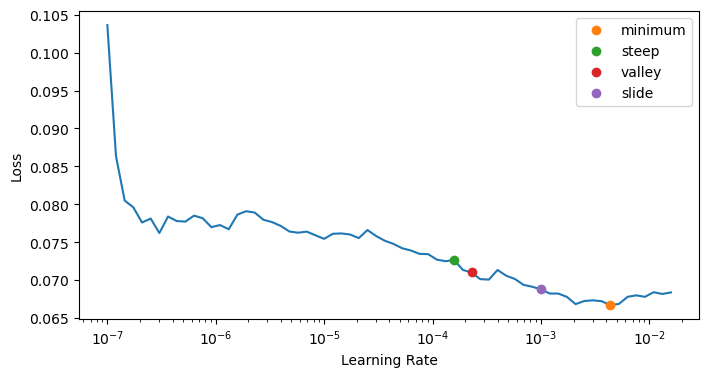

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum,steep,valley,slide), num_it=100)

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.00043651582673192023,
 0.00015848931798245758,
 0.0002290867705596611,
 0.0010000000474974513)

In [ ]:
# learn.fit_one_cycle(1, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)
for i in range(3, 0, -1):
    learn.fit_one_cycle(1, lr_max=1e-3*i, moms=(0.8,0.7,0.8), wd=0.1)
    learn.fit_one_cycle(5, lr_max=1e-3*i, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.042745,0.072136,0.446667,00:12


epoch,train_loss,valid_loss,precision_at_k,time
0,0.042994,0.071712,0.453333,00:11
1,0.042261,0.075044,0.450000,00:11
2,0.041705,0.074658,0.456667,00:11
3,0.040608,0.075577,0.446667,00:11
4,0.039769,0.075746,0.446667,00:13


epoch,train_loss,valid_loss,precision_at_k,time
0,0.042843,0.071680,0.460000,00:12


epoch,train_loss,valid_loss,precision_at_k,time
0,0.043052,0.071593,0.470000,00:12
1,0.042404,0.072811,0.460000,00:12
2,0.041661,0.073665,0.463333,00:12
3,0.040861,0.074412,0.456667,00:12
4,0.040264,0.074554,0.456667,00:11


epoch,train_loss,valid_loss,precision_at_k,time
0,0.043041,0.071457,0.466667,00:11


epoch,train_loss,valid_loss,precision_at_k,time
0,0.043180,0.071420,0.466667,00:13
1,0.042783,0.071878,0.456667,00:11
2,0.042280,0.072338,0.453333,00:12
3,0.041820,0.072718,0.460000,00:11
4,0.041488,0.072763,0.460000,00:11


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [3.588356645241649e-05,3.588356645241649e-05,3.588356645241649e-05,3.588356645241649e-05,3.588356645241649e-05]

In [ ]:
validate(learn)

best so far = 0.29333333333333333


[0.07909457385540009, 0.29333333333333333]
best so far = 0.29333333333333333


## Fine-Tune the Fwd (Dev|Tiny)

In [ ]:
learn = learn.load(learn.save_model.fname)
validate(learn)

best so far = 0.35666666666666663


[0.0721030980348587, 0.35666666666666663]
best so far = 0.35666666666666663


In [ ]:
learn.save_model.reset_on_fit = False
learn.save_model.fname

'mimic3-9k_plant_tiny'

**Without Gradual Unfreezing:**

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(40, lr=1e-2)

**With Gradual Unfreezing:**

In [ ]:
learn.fit(2, lr=7e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.158084,0.169444,0.081889,0.266667,00:14
1,0.097629,0.317222,0.074729,0.310000,00:12


Better model found at epoch 0 with valid_precision_at_k value: 0.26666666666666666.
Better model found at epoch 1 with valid_precision_at_k value: 0.31.


In [ ]:
learn.fit(3, lr=7e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.044402,0.393333,0.072972,0.316667,00:13
1,0.040360,0.455278,0.073715,0.320000,00:12
2,0.037128,0.510278,0.074080,0.333333,00:12


Better model found at epoch 0 with valid_precision_at_k value: 0.31666666666666665.
Better model found at epoch 1 with valid_precision_at_k value: 0.31999999999999995.
Better model found at epoch 2 with valid_precision_at_k value: 0.33333333333333337.


In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(10, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.031706,0.518611,0.074778,0.330000,00:12
1,0.029115,0.577778,0.074167,0.323333,00:14
2,0.027170,0.623889,0.073935,0.326667,00:12
3,0.025250,0.663889,0.073141,0.343333,00:12
4,0.023420,0.695833,0.072706,0.350000,00:12
5,0.021679,0.716111,0.071717,0.343333,00:12
6,0.019860,0.747778,0.070571,0.343333,00:14
7,0.018094,0.761667,0.071301,0.343333,00:12
8,0.016286,0.779167,0.071361,0.346667,00:12
9,0.014583,0.790833,0.072892,0.330000,00:12


Better model found at epoch 3 with valid_precision_at_k value: 0.3433333333333333.
Better model found at epoch 4 with valid_precision_at_k value: 0.35.


In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(10, lr=1e-3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.017726,0.732500,0.072529,0.350000,00:12
1,0.017488,0.735833,0.072422,0.350000,00:12
2,0.017447,0.736111,0.072332,0.353333,00:12
3,0.017349,0.737778,0.072269,0.353333,00:14
4,0.017306,0.739722,0.072211,0.353333,00:12
5,0.017237,0.740833,0.072194,0.350000,00:12
6,0.017098,0.738611,0.072182,0.350000,00:15
7,0.016994,0.742500,0.072149,0.353333,00:12
8,0.016878,0.742222,0.072103,0.356667,00:12
9,0.016803,0.746667,0.072081,0.356667,00:16


Better model found at epoch 2 with valid_precision_at_k value: 0.35333333333333333.
Better model found at epoch 8 with valid_precision_at_k value: 0.35666666666666663.


In [ ]:
learn.fit(10, lr=1e-3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.015915,0.741944,0.071381,0.336667,00:28
1,0.014384,0.746667,0.072199,0.340000,00:27
2,0.013158,0.759167,0.074667,0.340000,00:27
3,0.012156,0.768333,0.076125,0.336667,00:28
4,0.011213,0.773056,0.079213,0.330000,00:29
5,0.010369,0.783333,0.080655,0.336667,00:27
6,0.009531,0.788333,0.084583,0.323333,00:27
7,0.008775,0.791667,0.084480,0.330000,00:27
8,0.007997,0.797222,0.087817,0.336667,00:27
9,0.007294,0.800000,0.089813,0.326667,00:32


In [ ]:
# all_equal(*learn.opt.param_lists[:2])
# torch.equal(learn.opt.param_lists[6][0].data, learn.model[-1].pay_attn.lbs.weight.data)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(25, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.014555,0.765833,0.068510,0.356667,00:26
1,0.014453,0.765000,0.068510,0.360000,00:26
2,0.014452,0.764722,0.068508,0.356667,00:26
3,0.014430,0.761944,0.068506,0.356667,00:26
4,0.014436,0.763056,0.068505,0.356667,00:26
5,0.014410,0.764167,0.068504,0.356667,00:26
6,0.014364,0.765278,0.068504,0.356667,00:25
7,0.014348,0.762778,0.068503,0.356667,00:26
8,0.014361,0.763889,0.068502,0.356667,00:25
9,0.014366,0.763333,0.068502,0.356667,00:26


Better model found at epoch 1 with valid_precision_at_k value: 0.36.


## Fine-Tune the Fwd (Dev|Full)

In [28]:
learn.opt.hypers

(#7) [{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}]

In [29]:
learn.opt.set_hypers(mom=0.99)

In [30]:
learn.opt.hypers

(#7) [{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.99, 'eps': 1e-05}]

In [31]:
learn.freeze_to(-2)

In [ ]:
learn.fit(10, lr=[1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 7e-4, 3e-2], wd=[0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.01])

## Checking how to avoid overfitting:

In [ ]:
learn.save_model.reset_on_fit=False

In [ ]:
learn.fit(10, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.391221,0.074167,0.197629,0.196667,00:13
1,0.218384,0.225556,0.080403,0.253333,00:13
2,0.147795,0.256389,0.068796,0.270000,00:12
3,0.111931,0.277778,0.067111,0.276667,00:12
4,0.090809,0.308333,0.066692,0.276667,00:12
5,0.077108,0.332222,0.066395,0.286667,00:13
6,0.067511,0.354722,0.066039,0.280000,00:14
7,0.060452,0.377500,0.065895,0.296667,00:12
8,0.054908,0.410556,0.065720,0.310000,00:12
9,0.050470,0.431944,0.065801,0.316667,00:12


Better model found at epoch 0 with valid_precision_at_k value: 0.19666666666666666.
Better model found at epoch 1 with valid_precision_at_k value: 0.2533333333333333.
Better model found at epoch 2 with valid_precision_at_k value: 0.27.
Better model found at epoch 3 with valid_precision_at_k value: 0.2766666666666667.
Better model found at epoch 5 with valid_precision_at_k value: 0.2866666666666667.
Better model found at epoch 7 with valid_precision_at_k value: 0.29666666666666675.
Better model found at epoch 8 with valid_precision_at_k value: 0.31.
Better model found at epoch 9 with valid_precision_at_k value: 0.31666666666666665.


In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.042890,0.413056,0.069452,0.303333,00:16
1,0.037558,0.481111,0.068302,0.340000,00:17
2,0.033383,0.543333,0.073505,0.313333,00:16
3,0.029333,0.617500,0.076961,0.306667,00:16
4,0.025810,0.668889,0.083302,0.286667,00:16


Better model found at epoch 1 with valid_precision_at_k value: 0.34.


In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.032361,0.489444,0.072848,0.313333,00:20
1,0.027504,0.595278,0.077162,0.286667,00:21
2,0.023695,0.679722,0.082962,0.290000,00:22
3,0.019833,0.746389,0.091231,0.306667,00:22
4,0.016458,0.782500,0.097963,0.300000,00:23


In [ ]:
learn.opt.hypers

(#5) [{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.01, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.01, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.01, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.01, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.01, 'mom': 0.9, 'eps': 1e-05}]

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, max_len=72*40, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs, 
                                   drop_mult=0.1,
                                   pretrained=False,
                                   splitter=None,
                                   running_decoder=True).to_fp16()

In [ ]:
# tell `Recorder` to track `train_metrics`
assert learn.cbs[1].__class__ is Recorder
setattr(learn.cbs[1], 'train_metrics', True)

In [ ]:
@patch
def after_batch(self: ProgressCallback):
        self.pbar.update(self.iter+1)
        mets = ('_valid_mets', '_train_mets')[self.training]
        self.pbar.comment = ' '.join([f'{met.name} = {met.value.item():.4f}' for met in getattr(self.recorder, mets)])

In [ ]:
learn = learn.load(learn.save_model.fname)
validate(learn)

best so far = 0.3433333333333334
[0.06831542402505875, 0.3433333333333334]
best so far = 0.3433333333333334


In [ ]:
learn.save_model.best=0.34333

In [ ]:
learn.unfreeze()

In [ ]:
# %%debug
learn.fit(10, lr=1e-6, wd=0.3)

In [ ]:
# learn.opt.hypers, learn.wd, learn.lr

## Fine-Tuning the Bwd Classifier 

In [ ]:
# learn_r.opt.hypers#.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

In [ ]:
learn_r.fit(2, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.007564,0.384488,0.008315,0.454982,39:42
1,0.006742,0.458227,0.007797,0.481930,38:37


Better model found at epoch 0 with valid_precision_at_k value: 0.45498220640569376.
Better model found at epoch 1 with valid_precision_at_k value: 0.48192961644918897.


In [ ]:
learn_r.fit(9, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006838,0.473014,0.007535,0.494899,39:47
1,0.007002,0.479700,0.007376,0.503084,40:23
2,0.006739,0.482954,0.007317,0.506702,40:47
3,0.006478,0.485122,0.007257,0.506445,40:42
4,0.006433,0.486549,0.007218,0.511052,39:54
5,0.006414,0.487762,0.007178,0.510320,40:14
6,0.006309,0.489128,0.007146,0.514353,40:14
7,0.006853,0.489367,0.007107,0.514334,40:19
8,0.006412,0.489717,0.007141,0.513741,39:47


Better model found at epoch 0 with valid_precision_at_k value: 0.49489916963226593.
Better model found at epoch 1 with valid_precision_at_k value: 0.5030842230130488.
Better model found at epoch 2 with valid_precision_at_k value: 0.506702253855279.
Better model found at epoch 4 with valid_precision_at_k value: 0.511051799130091.
Better model found at epoch 6 with valid_precision_at_k value: 0.5143534994068806.


In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit(14, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.005077,0.504411,0.006206,0.537722,52:54
1,0.005185,0.512415,0.006007,0.545275,50:30
2,0.004890,0.516533,0.005913,0.547687,52:12
3,0.004909,0.520331,0.005819,0.553341,51:44
4,0.004789,0.522809,0.005807,0.551839,52:14
5,0.004796,0.526800,0.005746,0.557750,54:06
6,0.004978,0.529563,0.005712,0.562772,51:44
7,0.004752,0.531859,0.005678,0.562060,54:39
8,0.004784,0.533404,0.005707,0.559035,53:30


Better model found at epoch 0 with valid_precision_at_k value: 0.5377224199288257.
Better model found at epoch 1 with valid_precision_at_k value: 0.5452748121787271.
Better model found at epoch 2 with valid_precision_at_k value: 0.5476868327402139.
Better model found at epoch 3 with valid_precision_at_k value: 0.5533412415974692.
Better model found at epoch 5 with valid_precision_at_k value: 0.5577500988533018.
Better model found at epoch 6 with valid_precision_at_k value: 0.5627718465796757.


In [ ]:
learn_r.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004934,0.530920,0.005644,0.562396,53:13
1,0.004600,0.533206,0.005640,0.562119,53:24
2,0.004838,0.534152,0.005616,0.564591,53:26
3,0.004992,0.535571,0.005625,0.563721,56:08
4,0.004729,0.537246,0.005623,0.564690,52:13


Better model found at epoch 2 with valid_precision_at_k value: 0.5645907473309606.
Better model found at epoch 4 with valid_precision_at_k value: 0.5646896006326609.


In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004512,0.542960,0.005425,0.574812,1:08:34
1,0.004399,0.549391,0.005388,0.580803,1:07:03
2,0.004393,0.551346,0.005378,0.580269,1:11:35
3,0.004305,0.552264,0.005399,0.580249,1:07:49
4,0.004638,0.552713,0.005320,0.582780,1:10:15


Better model found at epoch 0 with valid_precision_at_k value: 0.5748121787267698.
Better model found at epoch 1 with valid_precision_at_k value: 0.5808026888098061.
Better model found at epoch 4 with valid_precision_at_k value: 0.5827797548438116.


In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.fit(8, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004360,0.564825,0.005301,0.584322,1:21:00
1,0.004090,0.566434,0.005286,0.585765,1:23:50
2,0.004282,0.567989,0.005273,0.587050,1:22:50
3,0.004444,0.569103,0.005261,0.588078,1:23:37
4,0.004214,0.570427,0.005251,0.588790,1:22:28
5,0.004118,0.571420,0.005242,0.589522,1:21:29
6,0.004051,0.572369,0.005234,0.590134,1:39:58
7,0.004023,0.573819,0.005226,0.590589,1:23:11


Better model found at epoch 0 with valid_precision_at_k value: 0.5843218663503366.
Better model found at epoch 1 with valid_precision_at_k value: 0.58576512455516.
Better model found at epoch 2 with valid_precision_at_k value: 0.5870502174772637.
Better model found at epoch 3 with valid_precision_at_k value: 0.5880782918149465.
Better model found at epoch 4 with valid_precision_at_k value: 0.5887900355871885.
Better model found at epoch 5 with valid_precision_at_k value: 0.5895215500197706.
Better model found at epoch 6 with valid_precision_at_k value: 0.5901344404903124.
Better model found at epoch 7 with valid_precision_at_k value: 0.5905891656781339.


In [ ]:
learn_r.fit(2, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.003961,0.575112,0.005219,0.591182,1:21:12
1,0.003683,0.577906,0.005213,0.591894,1:20:49


Better model found at epoch 0 with valid_precision_at_k value: 0.5911822854883352.
Better model found at epoch 1 with valid_precision_at_k value: 0.591894029260577.


In [ ]:
learn_r.fit(10, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004261,0.574649,0.005207,0.592329,1:24:13
1,0.004006,0.575258,0.005201,0.592724,1:21:54
2,0.004200,0.575567,0.005196,0.592803,1:24:06
3,0.004367,0.576012,0.005191,0.593041,1:25:26
4,0.004151,0.576616,0.005186,0.593575,1:27:14
5,0.004059,0.577233,0.005182,0.594089,1:26:12
6,0.003996,0.577824,0.005178,0.594365,1:28:34
7,0.003973,0.578928,0.005174,0.594504,1:24:08
8,0.003915,0.579819,0.005170,0.594919,1:25:19
9,0.003663,0.582147,0.005166,0.595275,1:24:36


Better model found at epoch 0 with valid_precision_at_k value: 0.5923289837880584.
Better model found at epoch 1 with valid_precision_at_k value: 0.5927243969948597.
Better model found at epoch 2 with valid_precision_at_k value: 0.5928034796362198.
Better model found at epoch 3 with valid_precision_at_k value: 0.593040727560301.
Better model found at epoch 4 with valid_precision_at_k value: 0.5935745353894823.
Better model found at epoch 5 with valid_precision_at_k value: 0.5940885725583238.
Better model found at epoch 6 with valid_precision_at_k value: 0.5943653618030844.
Better model found at epoch 7 with valid_precision_at_k value: 0.5945037564254647.
Better model found at epoch 8 with valid_precision_at_k value: 0.5949189402926058.
Better model found at epoch 9 with valid_precision_at_k value: 0.5952748121787272.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004219,0.578651,0.005163,0.595888,1:29:03
1,0.003969,0.578949,0.005159,0.596303,1:33:03
2,0.004162,0.579253,0.005156,0.596718,1:28:22
3,0.004331,0.579554,0.005153,0.596758,1:25:06
4,0.004119,0.580130,0.005150,0.597133,1:27:07
5,0.004029,0.580469,0.005148,0.597351,1:25:24
6,0.003968,0.580746,0.005145,0.597568,1:28:07
7,0.003946,0.581680,0.005142,0.597786,1:24:29
8,0.003890,0.582365,0.005140,0.597924,1:25:56
9,0.003661,0.584672,0.005138,0.598062,1:24:18


Better model found at epoch 0 with valid_precision_at_k value: 0.5958877026492689.
Better model found at epoch 1 with valid_precision_at_k value: 0.5963028865164102.
Better model found at epoch 2 with valid_precision_at_k value: 0.5967180703835511.
Better model found at epoch 3 with valid_precision_at_k value: 0.5967576117042313.
Better model found at epoch 4 with valid_precision_at_k value: 0.5971332542506922.
Better model found at epoch 5 with valid_precision_at_k value: 0.597350731514433.
Better model found at epoch 6 with valid_precision_at_k value: 0.5975682087781735.
Better model found at epoch 7 with valid_precision_at_k value: 0.5977856860419142.
Better model found at epoch 8 with valid_precision_at_k value: 0.5979240806642946.
Better model found at epoch 9 with valid_precision_at_k value: 0.598062475286675.
Better model found at epoch 10 with valid_precision_at_k value: 0.5981810992487153.
Better model found at epoch 11 with valid_precision_at_k value: 0.5983985765124561.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004192,0.581391,0.005131,0.598517,1:29:22
1,0.003944,0.581576,0.005129,0.598715,1:25:02
2,0.004137,0.581732,0.005127,0.598952,1:25:53
3,0.004306,0.581890,0.005125,0.599091,1:26:09
4,0.004097,0.582328,0.005123,0.599308,1:25:22
5,0.004008,0.582727,0.005122,0.599387,1:25:37
6,0.003949,0.582932,0.005120,0.599249,1:27:32
7,0.003927,0.583663,0.005119,0.599585,1:30:06
8,0.003872,0.584260,0.005117,0.599703,1:26:04
9,0.003669,0.586653,0.005116,0.599941,1:28:20


Better model found at epoch 0 with valid_precision_at_k value: 0.5985172004744963.
Better model found at epoch 1 with valid_precision_at_k value: 0.5987149070778969.
Better model found at epoch 2 with valid_precision_at_k value: 0.5989521550019774.
Better model found at epoch 3 with valid_precision_at_k value: 0.5990905496243577.
Better model found at epoch 4 with valid_precision_at_k value: 0.5993080268880984.
Better model found at epoch 5 with valid_precision_at_k value: 0.5993871095294585.
Better model found at epoch 7 with valid_precision_at_k value: 0.5995848161328591.
Better model found at epoch 8 with valid_precision_at_k value: 0.5997034400948994.
Better model found at epoch 9 with valid_precision_at_k value: 0.5999406880189802.
Better model found at epoch 11 with valid_precision_at_k value: 0.600217477263741.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.4)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004177,0.583113,0.005111,0.600356,1:25:28
1,0.003931,0.583075,0.005110,0.600336,1:29:16
2,0.004125,0.583175,0.005109,0.600395,1:25:16
3,0.004296,0.583358,0.005109,0.600455,1:29:21
4,0.004089,0.583721,0.005108,0.600316,1:31:31
5,0.004001,0.583767,0.005107,0.600435,1:21:54
6,0.003945,0.583991,0.005107,0.600593,1:25:02
7,0.003924,0.584695,0.005107,0.600672,1:26:36
8,0.003871,0.585206,0.005106,0.601008,1:24:04
9,0.003696,0.587589,0.005106,0.600989,1:30:52


Better model found at epoch 2 with valid_precision_at_k value: 0.6003954132068013.
Better model found at epoch 3 with valid_precision_at_k value: 0.6004547251878214.
Better model found at epoch 6 with valid_precision_at_k value: 0.6005931198102016.
Better model found at epoch 7 with valid_precision_at_k value: 0.6006722024515617.
Better model found at epoch 8 with valid_precision_at_k value: 0.6010083036773427.
Better model found at epoch 10 with valid_precision_at_k value: 0.6011862396204035.


In [ ]:
learn_r.fit(10, lr=1e-6, wd=0.4)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004128,0.583594,0.005105,0.601186,1:24:23
1,0.004299,0.583698,0.005105,0.601305,1:25:33
2,0.004092,0.584118,0.005105,0.601423,1:27:00
3,0.004005,0.584058,0.005105,0.601463,1:25:26
4,0.003949,0.584217,0.005105,0.601522,1:24:53
5,0.003928,0.584968,0.005105,0.601404,1:27:26
6,0.003875,0.585415,0.005105,0.601661,1:22:49
7,0.003719,0.587758,0.005105,0.601779,1:24:33
8,0.004059,0.583728,0.005105,0.601700,1:23:08
9,0.003960,0.583779,0.005105,0.601799,1:26:34


Better model found at epoch 0 with valid_precision_at_k value: 0.6011862396204033.
Better model found at epoch 1 with valid_precision_at_k value: 0.6013048635824436.
Better model found at epoch 2 with valid_precision_at_k value: 0.6014234875444842.
Better model found at epoch 3 with valid_precision_at_k value: 0.6014630288651643.
Better model found at epoch 4 with valid_precision_at_k value: 0.6015223408461846.
Better model found at epoch 6 with valid_precision_at_k value: 0.6016607354685648.
Better model found at epoch 7 with valid_precision_at_k value: 0.6017793594306049.
Better model found at epoch 9 with valid_precision_at_k value: 0.6017991300909451.


Start here:

In [ ]:
print(learn_r.save_model.fname)
learn_r.save_model.reset_on_fit = False
assert learn_r.save_model.reset_on_fit is False
learn_r = learn_r.load(learn_r.save_model.fname)
validate(learn_r)

mimic3-9k_clas_full_r
best so far = None


[0.005104772746562958, 0.6017991300909451]
best so far = None


In [ ]:
learn_r.save_model.best = 0.60179913

Now you can unfreeze and train more if you want:

In [ ]:
learn_r.unfreeze()

Ensemble:

In [ ]:
learn = learn.load(learn.save_model.fname)
learn_r = learn_r.load(learn_r.save_model.fname)
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()

In [ ]:
precision_at_k(preds.add(preds_r), targs, k=15)

0.6167457493080268

---

In [ ]:
set_seed(1, reproducible=True)

(0.2754228591918945,
 0.033113110810518265,
 0.002511886414140463,
 0.033113110810518265)

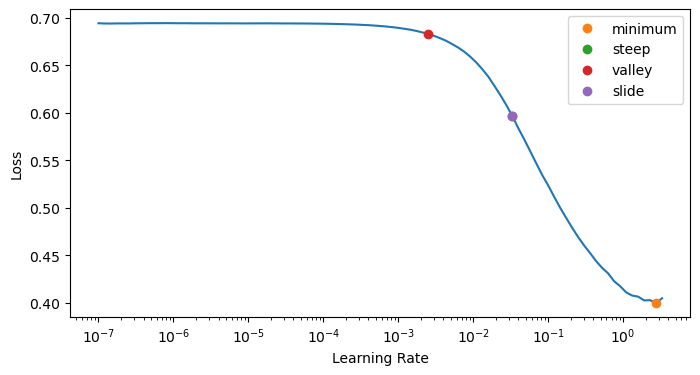

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn_r.fit_one_cycle(1, lr_max=0.14, moms=(0.8,0.7,0.8), wd=0.1)
learn_r.fit_one_cycle(5, lr_max=0.14, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.396181,0.218404,0.223333,00:05


Better model found at epoch 0 with precision_at_k value: 0.22333333333333333.


epoch,train_loss,valid_loss,precision_at_k,time
0,0.196439,0.160080,0.253333,00:04
1,0.164353,0.133897,0.240000,00:04
2,0.140529,0.114523,0.353333,00:05
3,0.119238,0.105214,0.373333,00:05
4,0.102833,0.103365,0.376667,00:05


Better model found at epoch 0 with precision_at_k value: 0.2533333333333333.
Better model found at epoch 2 with precision_at_k value: 0.35333333333333333.
Better model found at epoch 3 with precision_at_k value: 0.37333333333333335.
Better model found at epoch 4 with precision_at_k value: 0.37666666666666665.


In [ ]:
validate(learn_r)

best so far = 0.3166666666666667


[0.06839973479509354, 0.3166666666666667]
best so far = 0.3166666666666667


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit_one_cycle(1, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1)
learn_r.fit_one_cycle(4, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.066128,0.101364,0.363333,00:06


Better model found at epoch 0 with precision_at_k value: 0.36333333333333334.


epoch,train_loss,valid_loss,precision_at_k,time
0,0.063144,0.099782,0.373333,00:06
1,0.060468,0.100892,0.320000,00:06
2,0.058185,0.098354,0.353333,00:07
3,0.056312,0.096989,0.376667,00:05


Better model found at epoch 0 with precision_at_k value: 0.37333333333333335.
Better model found at epoch 3 with precision_at_k value: 0.37666666666666665.


In [ ]:
validate(learn_r)

best so far = 0.29000000000000004


[0.08007880300283432, 0.29000000000000004]
best so far = 0.29000000000000004


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.052942,0.098026,0.373333,00:08
1,0.053420,0.097696,0.373333,00:07
2,0.051679,0.097380,0.380000,00:07
3,0.049411,0.098192,0.370000,00:07
4,0.047627,0.097431,0.376667,00:08


Better model found at epoch 0 with precision_at_k value: 0.37333333333333335.
Better model found at epoch 2 with precision_at_k value: 0.38.


In [ ]:
validate(learn_r)

best so far = 0.2966666666666667


[0.08150946348905563, 0.2966666666666667]
best so far = 0.2966666666666667


Finally, we will unfreeze the whole model and perform training: (Caution: Check if you got enough memory left!)

In [ ]:
cudamem()

GPU: Quadro RTX 8000
You are using 9.798828125 GB
Total GPU memory = 44.99969482421875 GB


In [ ]:
learn_r.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

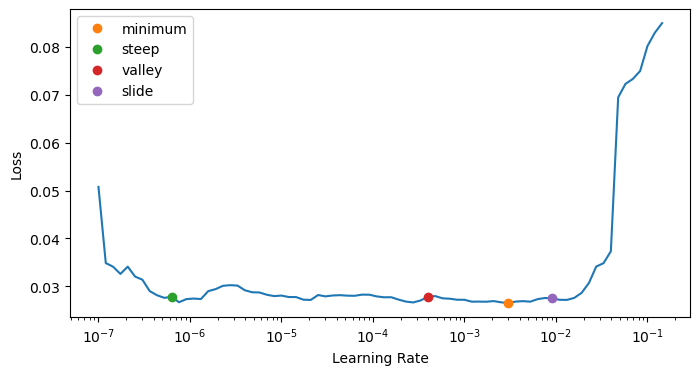

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum,steep,valley,slide), num_it=100)

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.0003019951749593019,
 6.309573450380412e-07,
 0.0003981071640737355,
 0.009120108559727669)

In [ ]:
learn_r.fit_one_cycle(10, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.064373,0.087895,0.296667,00:11
1,0.064310,0.087949,0.296667,00:10
2,0.063739,0.089096,0.293333,00:10
3,0.062852,0.090236,0.293333,00:10
4,0.062443,0.091487,0.293333,00:10
5,0.062105,0.091792,0.290000,00:10
6,0.061126,0.091894,0.286667,00:10
7,0.060621,0.092186,0.283333,00:10
8,0.060148,0.092261,0.283333,00:10
9,0.059983,0.092269,0.283333,00:10


Better model found at epoch 0 with precision_at_k value: 0.29666666666666675.


In [ ]:
validate(learn_r)

best so far = 0.2866666666666667


[0.08382819592952728, 0.2866666666666667]
best so far = 0.2866666666666667


Ensemble of fwd+bwd:

In [ ]:
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()
precision_at_k(preds+preds_r, targs, k=15)

0.3933333333333333

## TTA

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                   pretrained=False,
                                   splitter=None,
                                   running_decoder=True).to_fp16()
learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                     metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                     pretrained=False,
                                     splitter=None,
                                     running_decoder=True).to_fp16()  

In [ ]:
learn = learn.load(learn.save_model.fname)
# learn = learn.load((learn.path/learn.model_dir)/'mimic3-9k_clas_tiny')
learn_r = learn_r.load(learn_r.save_model.fname)

In [ ]:
validate(learn)

best so far = -inf


[0.005114026367664337, 0.5988730723606168]
best so far = -inf


In [ ]:
validate(learn_r)

best so far = -inf


[0.0051385280676186085, 0.5965005931198106]
best so far = -inf


In [ ]:
L(learn, learn_r).attrgot('model').itemgot(1)

(#2) [LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(8922, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=8922, bias=True)
  )
),LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(8922, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=8922, bias=True)
  )
)]

In [ ]:
from xcube.layers import *
from xcube.layers import _linear_attention, _planted_attention
from xcube.text.learner import _get_text_vocab, _get_label_vocab

In [ ]:
@patch 
def load_brain(self:TextLearner,
    file_wgts: str, # Filename of the saved attention wgts
    file_bias: str, # Filename of the saved label bias
    device:(int,str,torch.device)=None # Device used to load, defaults to `dls` device
    ):
    """Load the pre-learnt label specific attention weights for each token from `file` located in the 
    model directory, optionally ensuring it's one `device`
    """
    brain_path = join_path_file(file_wgts, self.path/self.model_dir, ext='.pkl')
    bias_path = join_path_file(file_bias, self.path/self.model_dir, ext='.pkl')
    brain_bootstrap = torch.load(brain_path, map_location=default_device() if device is None else device)
    *brain_vocab, brain = mapt(brain_bootstrap.get, ['toks', 'lbs', 'mutual_info_jaccard'])
    brain_vocab = L(brain_vocab).map(listify)
    vocab = L(_get_text_vocab(self.dls), _get_label_vocab(self.dls)).map(listify)
    brain_bias = torch.load(bias_path, map_location=default_device() if device is None else device)
    brain_bias = brain_bias[:, :, 0].squeeze(-1)
    print("Performing brainsplant...")
    self.brain, self.lbsbias, *_ = brainsplant(vocab, brain_vocab, brain, brain_bias)
    print("Successfull!")
    # import pdb; pdb.set_trace()
    plant_attn_layer = Lambda(Planted_Attention(self.brain))
    setattr(self.model[1].pay_attn, 'plant_attn', plant_attn_layer)
    assert self.model[1].pay_attn.plant_attn.func.f is _planted_attention
    return self

In [ ]:
# learn = learn.load_brain('mimic3-9k_tok_lbl_info', 'p_L')
learn_r = learn_r.load_brain('mimic3-9k_tok_lbl_info', 'p_L')

Performing brainsplant...


Successfull!


In [ ]:
L(learn, learn_r).attrgot('model').itemgot(1)

(#2) [LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(8922, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=8922, bias=True)
  )
),LabelAttentionClassifier(
  (pay_attn): XMLAttention(
    (lbs): Embedding(8922, 400)
    (attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
    (plant_attn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
  )
  (boost_attn): ElemWiseLin(
    (lin): Linear(in_features=400, out_features=8922, bias=True)
  )
)]

In [ ]:
@patch
def forward(self:XMLAttention, inp, sentc, mask):
    # sent is the ouput of SentenceEncoder i.e., (bs, max_len tokens, nh)
    test_eqs(inp.shape, sentc.shape[:-1], mask.shape)
    top_tok_attn_wgts = F.softmax(self.attn(sentc), dim=1).masked_fill(mask[:,:,None], 0) # lbl specific wts for each token (bs, max_len, n_lbs)
    attn_wgts = self.plant_attn(inp).masked_fill(mask[:,:,None], 0) #shape (bs, bptt, n_lbs)
    top_lbs_attn_wgts = attn_wgts.inattention(k=1, sort_dim=-1, sp_dim=1) # applying `inattention` across the lbs dim
    lbs_cf = top_lbs_attn_wgts.sum(dim=1) #shape (bs, n_lbs)
    # pdb.set_trace()
    return lincomb(sentc, wgts=top_tok_attn_wgts.transpose(1,2)), top_tok_attn_wgts, lbs_cf # for each lbl do a linear combi of all the tokens based on attn_wgts (bs, num_lbs, nh)

In [ ]:
from xcube.text.models.core import _pad_tensor

In [ ]:
@patch
def forward(self:LabelAttentionClassifier, sentc):
    if isinstance(sentc, tuple): inp, sentc, mask = sentc # sentc is the stuff coming outta SentenceEncoder i.e., shape (bs, max_len, nh) in other words the concatenated output of the AWD_LSTM
    test_eqs(inp.shape, sentc.shape[:-1], mask.shape)
    sentc = sentc.masked_fill(mask[:, :, None], 0)
    attn, wgts, lbs_cf = self.pay_attn(inp, sentc, mask) #shape attn: (bs, n_lbs, n_hidden), wgts: (bs, max_len, n_lbs), lbs_cf : (bs, n_lbs)
    attn = self.boost_attn(attn) # shape (bs, n_lbs, n_hidden)
    bs = self.hl.size(0)
    self.hl = self.hl.to(sentc.device)
    pred = self.hl + _pad_tensor(attn.sum(dim=2), bs) + self.label_bias  # shape (bs, n_lbs)

    if self.y_range is not None: pred = sigmoid_range(pred, *self.y_range)
    return pred, attn, wgts, lbs_cf 

In [ ]:
@patch
def after_pred(self:RNNCallback): self.learn.pred,self.raw_out,self.out, _ = [o[-1] if is_listy(o) else o for o in self.pred]

In [ ]:
from xcube.layers import inattention

In [ ]:
class FetchCallback(Callback):
    order=RNNCallback.order-1
    "Save the preds, attention wgts and labels confidence outputs"
    
    def __init__(self, predslog, rank): store_attr()
    
    def before_validate(self):
        self.predslog =  open(self.predslog, 'wb')
        self.csv_rank =  open(self.rank, 'w', newline='')
        self.writer_rank = csv.writer(self.csv_rank)
        self.writer_rank.writerow(L('subset', '#true (t)', '#true^subset (ts)', '% (ts/t)', '#top_preds', '#top_preds^subset', '#true^top_preds (ttp)', '#top_preds^subset^true', 'precision (ttp/15)', '#true^topk (ttk)', 'prec (ttk/15)'))
    
    @staticmethod
    def _get_stat(y, cf, preds):
        subset = cf>0
        truth = y.sum()
        num_true_subset = torch.logical_and(y == 1, subset).sum()
        assert preds.logical_and(tensor(1)).all() # check preds does not have any zeros
        top_preds = preds.inattention(k=14)
        num_top_preds = torch.as_tensor(top_preds.nonzero().flatten().numel())
        num_top_preds_subset = torch.logical_and(top_preds, subset).sum() #
        num_true_top_preds = torch.logical_and(y==1, top_preds).sum()
        num_top_preds_subset_true = torch.logical_and(top_preds, subset).logical_and(y==1).sum()#
        topk = preds.topk(k=15).indices
        num_true_topk = y[topk].sum()
        _d = dict(subsum = subset.sum(), num_truth = truth, num_true_subset = num_true_subset, pct_true_subset = num_true_subset.div(truth).mul(100), 
                    num_top_preds = num_top_preds, num_top_preds_subset = num_top_preds_subset, true_top_preds = num_true_top_preds, 
                    num_top_preds_subset_also_true =  num_top_preds_subset_true, 
                    prec_shdbe = torch.min(num_true_top_preds.div(15.0), torch.tensor(1)), 
                    num_true_top_k=num_true_topk, prec=num_true_topk.div(15))
        # pdb.set_trace()
        return L(_d.values()).map(Self.item())
    
    def after_pred(self): 
        self.actual_pred, self.attn, self.wgts, self.lbs_cf = [o[-1] if is_listy(o) else o for o in self.pred]
        for y,cf, preds in zip(self.y, self.lbs_cf, self.actual_pred):
            # self.writer_predslog.writerow(L(y, cf, preds).map(cpupy))
            # self.csv_predslog.flush()
            pickle.dump((y,cf,preds), self.predslog)
            self.writer_rank.writerow(FetchCallback._get_stat(y, cf, preds))
            self.csv_rank.flush()

    def after_validate(self): 
        self.predslog.close(); 
        self.csv_rank.close()

In [ ]:
validate(learn)

best so far = None


[0.005114026367664337, 0.5988730723606168]
best so far = None


In [ ]:
validate(learn_r)

best so far = -inf


[0.0051385280676186085, 0.5965005931198106]
best so far = -inf


In [ ]:
predslog = join_path_file(fname+'_predslog', learn.path/learn.model_dir, ext='.pkl')
rank = join_path_file(fname+'_rank', learn.path/learn.model_dir, ext='.csv')
fc = FetchCallback(predslog, rank)

In [ ]:
print(f"pid = {os.getpid()}")
with learn.added_cbs([fc]):
    validate(learn)

pid = 1791


[0.0052354661747813225, 0.5901542111506525]


In [ ]:
with open(Path.cwd()/'tmp.pkl', 'wb') as pf:
    for _ in range(7):
        tl = [torch.randn(5) for _ in range(3)]
        print(tl)
        pickle.dump(tl, pf)

In [ ]:
# with open(Path.cwd()/'tmp.pkl', 'rb') as f:
with open(predslog, 'rb') as f:
    while True:
        try:
            obj = pickle.load(f)
            print(obj)
        except EOFError: break

In [ ]:
datetime.fromtimestamp(predslog.stat().st_mtime).time()

datetime.time(18, 21, 50, 118789)

In [ ]:
with open(predslog, 'rb') as preds_file, open(rank, 'w', newline='') as rank_file:
    writer = csv.writer(rank_file)
    writer.writerow(L('subset', '#true (t)', '#true^subset (ts)', '% (ts/t)', '#top_preds', '#top_preds^subset', '#true^top_preds (ttp)', '#top_preds^subset^true', 'precision (ttp/15)', '#true^topk (ttk)', 'prec (ttk/15)'))
    while True:
        try:
            y, cf, preds = pickle.load(preds_file)
            writer.writerow(FetchCallback._get_stat(y, cf, preds))
            rank_file.flush()
        except EOFError: break

In [ ]:
datetime.fromtimestamp(rank.stat().st_mtime).time()

datetime.time(18, 35, 9, 58730)

In [ ]:
df_rank = pd.read_csv(rank)
print(f"{len(df_rank)=}")
df_rank.head()

len(df_rank)=3372


,subset,#true (t),#true^subset (ts),% (ts/t),#top_preds,#top_preds^subset,#true^top_preds (ttp),#top_preds^subset^true,precision (ttp/15),#true^topk (ttk),prec (ttk/15)
0,936,39.0,33,84.615387,15,15,9,9,0.600000,9.0,0.600000
1,827,38.0,30,78.947372,15,15,13,13,0.866667,13.0,0.866667
2,700,40.0,32,80.000000,15,15,13,13,0.866667,13.0,0.866667
3,797,27.0,17,62.962959,15,14,8,7,0.533333,8.0,0.533333
4,642,30.0,27,90.000000,15,14,9,8,0.600000,9.0,0.600000


We are missing out on:

In [ ]:
df_rank[df_rank['#true^top_preds (ttp)'] != df_rank['#true^topk (ttk)']]

,subset,#true (t),#true^subset (ts),% (ts/t),#top_preds,#top_preds^subset,#true^top_preds (ttp),#top_preds^subset^true,precision (ttp/15),#true^topk (ttk),prec (ttk/15)


In [ ]:
df_rank[df_rank['#true^top_preds (ttp)'] - df_rank['#top_preds^subset^true'] >= 1]

,subset,#true (t),#true^subset (ts),% (ts/t),#top_preds,#top_preds^subset,#true^top_preds (ttp),#top_preds^subset^true,precision (ttp/15),#true^topk (ttk),prec (ttk/15)
3,797,27.0,17,62.962959,15,14,8,7,0.533333,8.0,0.533333
4,642,30.0,27,90.000000,15,14,9,8,0.600000,9.0,0.600000
11,782,15.0,12,80.000000,15,13,10,9,0.666667,10.0,0.666667
18,656,22.0,15,68.181816,15,14,9,8,0.600000,9.0,0.600000
21,653,38.0,31,81.578949,15,14,11,10,0.733333,11.0,0.733333
...,...,...,...,...,...,...,...,...,...,...,...
3363,203,14.0,10,71.428574,15,12,8,7,0.533333,8.0,0.533333
3364,122,6.0,4,66.666672,15,11,5,4,0.333333,5.0,0.333333
3366,168,18.0,13,72.222221,15,10,8,6,0.533333,8.0,0.533333
3367,167,18.0,9,50.000000,15,10,12,8,0.800000,12.0,0.800000


TODO:
- Implement sortish=shuffle+split+sort+cat

In [ ]:
df_rank['precision (ttp/15)'].mean(), df_rank['prec (ttk/15)'].mean()

(0.590154242462093, 0.590154242462093)

In [ ]:
df = pd.DataFrame({
    'Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Age': [25, 30, 35, 40],
    'Salary': [50000, 60000, 70000, 80000]
})
df.style.applymap(lambda _: f"color:{'blue'}", subset=['Salary', 'Name'])

,Name,Age,Salary
0,Alice,25,50000
1,Bob,30,60000
2,Charlie,35,70000
3,David,40,80000


In [ ]:
# df.loc[df['precision (tpc/t)'] > 1.0, 'precision (tpc/t)'] = 1.0
# df.head()
# df.loc[:, 'precision (tpc/t)'].mean(), df['prec'].mean()

In [ ]:
tbar = tqdm(learn.dls.valid, leave=False) 
for xb,yb in tbar:
    tbar.set_postfix({'xb':xb.shape, 'yb': yb.shape})
    pred, *_ = learn.model(xb)
    prec = precision_at_k(pred, yb)
    print(prec)

  0%|          | 0/211 [00:00<?, ?it/s]

0.6833333333333333
0.6791666666666667
0.65
0.6625000000000001
0.7083333333333334
0.7458333333333333
0.6375
0.675
0.7
0.6000000000000001
0.6625000000000001
0.7041666666666666
0.6666666666666666
0.6875
0.7416666666666667
0.65
0.6458333333333334
0.675
0.5958333333333333
0.7166666666666666
0.6791666666666667
0.6666666666666667
0.6
0.6749999999999999
0.6666666666666666
0.6291666666666667
0.7541666666666667
0.6666666666666667
0.6416666666666666
0.6416666666666666
0.7083333333333333
0.6458333333333334
0.6916666666666667
0.6833333333333333
0.6916666666666667
0.6375
0.6375000000000001
0.6125
0.6541666666666667
0.7000000000000001
0.7125000000000001
0.6291666666666667
0.6624999999999999
0.6166666666666667
0.6625000000000001
0.75
0.6916666666666667
0.6958333333333333
0.6291666666666667
0.6666666666666667
0.5625
0.6041666666666666
0.75
0.6291666666666667
0.6041666666666666
0.65
0.6458333333333333
0.6791666666666667
0.5833333333333333
0.6333333333333333
0.6416666666666666
0.5833333333333333
0.579166

## Plotting the Label Embeddings

> To know if the model learnt embeddings that are meaningful

In [ ]:
lbs_emb = learn.model[-1].pay_attn.lbs.weight
X = to_np(lbs_emb)

Now let's do a PCA and t-SNE on the labels embedding. Before doing PCA though we need to standardize `X`:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_stand = StandardScaler().fit_transform(X)

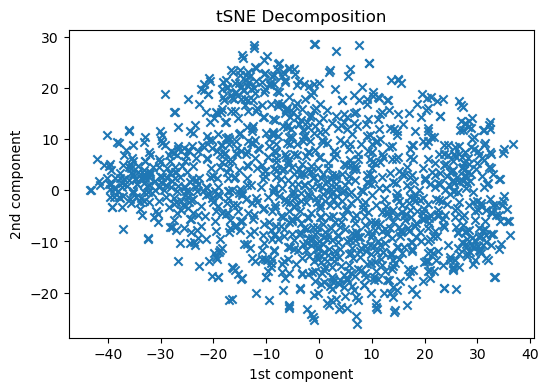

In [ ]:
X_reduced, _vars = plot_reduction(X, tSNE=True) 
# X_random, _vars_rnd = plot_reduction(np.random.normal(size=(X.shape[0], 400)), tSNE=True) # to compare with a random embeddings

In [ ]:
# print('\n'.join(L(source.glob('**/*desc*')).map(str)))
codes = load_pickle(source/'code_desc.pkl')
df_lbl = pd.DataFrame([(lbl, codes.get(lbl, "not found"), freq) for lbl, freq in lbl_freqs.items()], columns=['label', 'description', 'frequency'])
df_lbl = df_lbl.sort_values(by='frequency', ascending=False, ignore_index=True)
df_lbl.head()

,label,description,frequency
0,401.9,Unspecified essential hypertension,84
1,38.93,"Venous catheterization, not elsewhere classified",77
2,428.0,"Congestive heart failure, unspecified",61
3,272.4,Other and unspecified hyperlipidemia,60
4,427.31,Atrial fibrillation,56


Instead of doing a PCA on all the labels, let's do it on the `top` most frequent labels:

In [ ]:
top = 100
top_lbs = [k for k, v in lbl_freqs.most_common(top)]
tfm_cat = dls_clas.tfms[1][1]
top_lbs_emb = lbs_emb[tfm_cat(top_lbs)]
topX = to_np(top_lbs_emb)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
topX_tsne = TSNE(n_components=2, perplexity=40).fit_transform(topX)

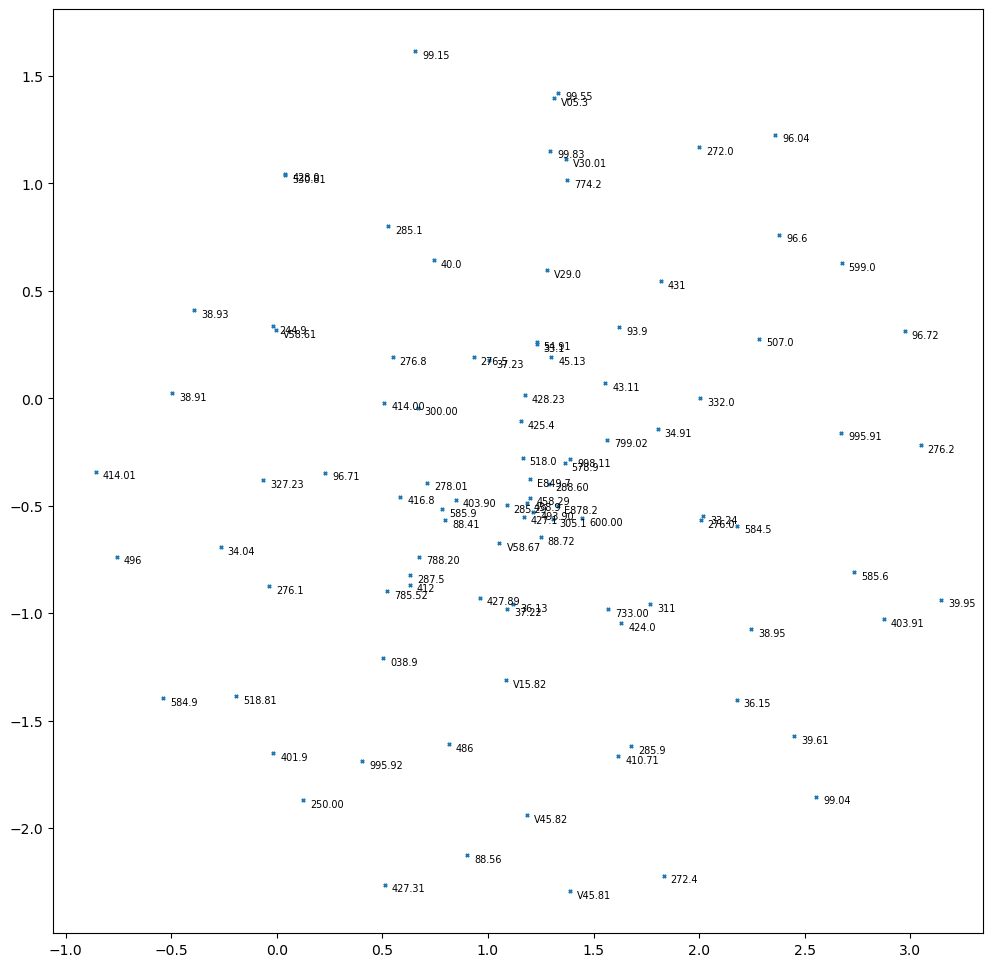

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(topX_tsne[:, 0], topX_tsne[:, 1], marker='x', s=5)
for lbl, x, y in zip(top_lbs, topX_tsne[:, 0], topX_tsne[:, 1]):
    plt.annotate(lbl,
                xy=(x,y),
                xytext=(5,-5),
                textcoords='offset points',
                size=7)
plt.show()

Take a look at some of the closely clustered labels to see if they have the same meaning. This will tell us if the model learned meaningful label embeddings:

In [ ]:
df_lbl[df_lbl.label.isin(['36.13', '995.91', '88.72', '37.22'])]

,label,description,frequency
48,88.72,Diagnostic ultrasound of heart,14
56,37.22,Left heart cardiac catheterization,13
64,995.91,Sepsis,11
70,36.13,(Aorto)coronary bypass of three coronary arteries,10


Looks like it did!